# Lead Scoring Case Study

In [1]:
# Importing essential libraries
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Exploratory Data Analysis

### Loading Data

In [2]:
# Loading data
df = pd.read_csv('Leads.csv')
df.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,...,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,...,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,...,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [3]:
df.shape

(9240, 37)

### Cleaning Data

#### Missing Values

In [4]:
df_missing = df.isnull().mean() * 100
df_missing[df_missing > 0]

Lead Source                                       0.389610
TotalVisits                                       1.482684
Page Views Per Visit                              1.482684
Last Activity                                     1.114719
Country                                          26.634199
Specialization                                   15.562771
How did you hear about X Education               23.885281
What is your current occupation                  29.112554
What matters most to you in choosing a course    29.318182
Tags                                             36.287879
Lead Quality                                     51.590909
Lead Profile                                     29.318182
City                                             15.367965
Asymmetrique Activity Index                      45.649351
Asymmetrique Profile Index                       45.649351
Asymmetrique Activity Score                      45.649351
Asymmetrique Profile Score                       45.6493

Large number of missing optional fields have been marked as `Select`. It also needs to be handled.

In [5]:
df = df.replace({'Select': np.nan})

In [6]:
df_missing = df.isnull().mean() * 100
df_missing[df_missing > 0]

Lead Source                                       0.389610
TotalVisits                                       1.482684
Page Views Per Visit                              1.482684
Last Activity                                     1.114719
Country                                          26.634199
Specialization                                   36.580087
How did you hear about X Education               78.463203
What is your current occupation                  29.112554
What matters most to you in choosing a course    29.318182
Tags                                             36.287879
Lead Quality                                     51.590909
Lead Profile                                     74.188312
City                                             39.707792
Asymmetrique Activity Index                      45.649351
Asymmetrique Profile Index                       45.649351
Asymmetrique Activity Score                      45.649351
Asymmetrique Profile Score                       45.6493

After consulting data dictionary, the columns having more than 40% missing values don't seem important for analysis. So, I am dropping them.

In [7]:
df.drop(df_missing[df_missing > 40].index, axis=1, inplace=True)

In [8]:
df.shape

(9240, 30)

In [9]:
df_missing = df.isnull().mean() * 100
df_missing[df_missing > 0]

Lead Source                                       0.389610
TotalVisits                                       1.482684
Page Views Per Visit                              1.482684
Last Activity                                     1.114719
Country                                          26.634199
Specialization                                   36.580087
What is your current occupation                  29.112554
What matters most to you in choosing a course    29.318182
Tags                                             36.287879
City                                             39.707792
dtype: float64

Removing rows with small percentage of missing value.

In [10]:
df = df[df['Lead Source'].notnull() & df['TotalVisits'].notnull() & df['Page Views Per Visit'].notnull() & df['Last Activity']]

In [11]:
df_missing = df.isnull().mean() * 100
df_missing[df_missing > 0]

Country                                          25.303064
Specialization                                   36.169275
What is your current occupation                  29.567996
What matters most to you in choosing a course    29.777386
Tags                                             36.665197
City                                             39.398281
dtype: float64

Imputing missing values.

In [12]:
df['Country'].value_counts(normalize=True) * 100

India                   95.765713
United States            1.017999
United Arab Emirates     0.781942
Singapore                0.354087
Saudi Arabia             0.309826
United Kingdom           0.221304
Australia                0.191797
Qatar                    0.147536
Hong Kong                0.103275
Bahrain                  0.103275
Oman                     0.088522
France                   0.088522
unknown                  0.073768
South Africa             0.059014
Nigeria                  0.059014
Germany                  0.059014
Kuwait                   0.059014
Canada                   0.059014
Sweden                   0.044261
China                    0.029507
Asia/Pacific Region      0.029507
Uganda                   0.029507
Bangladesh               0.029507
Italy                    0.029507
Belgium                  0.029507
Netherlands              0.029507
Ghana                    0.029507
Philippines              0.029507
Russia                   0.014754
Switzerland   

The missing value is most likely `India`.

In [13]:
# Imputing missing value with India
df['Country'] = df['Country'].fillna('India')

In [14]:
df['Specialization'].value_counts(normalize=True) * 100

Finance Management                   16.557320
Human Resource Management            14.450967
Marketing Management                 14.209254
Operations Management                 8.615331
Business Administration               6.888812
IT Projects Management                6.319061
Supply Chain Management               5.973757
Banking, Investment And Insurance     5.783840
Travel and Tourism                    3.487569
Media and Advertising                 3.487569
International Business                3.038674
Healthcare Management                 2.693370
E-COMMERCE                            1.916436
Hospitality Management                1.916436
Retail Management                     1.726519
Rural and Agribusiness                1.260359
E-Business                            0.984116
Services Excellence                   0.690608
Name: Specialization, dtype: float64

Creating new category for missing value as imputation with mode will create bias against comparable category at rank 2 and 3.

In [15]:
# Imputing missing value with a new category
df['Specialization'] = df['Specialization'].fillna('Others')

In [16]:
df['What is your current occupation'].value_counts(normalize=True) * 100

Unemployed              85.682992
Working Professional    10.593021
Student                  3.223283
Other                    0.234705
Housewife                0.140823
Businessman              0.125176
Name: What is your current occupation, dtype: float64

Missing values are most likely `Unemployed`.

In [17]:
# Imputing missing value with the mode
df['What is your current occupation'] = df['What is your current occupation'].fillna('Unemployed')

In [18]:
df['What matters most to you in choosing a course'].value_counts(normalize=True) * 100

Better Career Prospects      99.968613
Flexibility & Convenience     0.015694
Other                         0.015694
Name: What matters most to you in choosing a course, dtype: float64

In [19]:
df['What matters most to you in choosing a course'].value_counts()

Better Career Prospects      6370
Flexibility & Convenience       1
Other                           1
Name: What matters most to you in choosing a course, dtype: int64

The missing values are most likely `Better Career Prospects`, but imputing missing values with mode will add no value as the feature is already useless because other categories don't have enough frequency to compete with mode. So, this feature can be dropped.

In [20]:
df['Tags'].value_counts(normalize=True) * 100

Will revert after reading the email                  35.079172
Ringing                                              20.654254
Interested in other courses                           8.856795
Already a student                                     8.091178
Closed by Horizzon                                    5.237515
switched off                                          4.176092
Busy                                                  3.219071
Lost to EINS                                          2.992866
Not doing further education                           2.523056
Interested  in full time MBA                          2.018444
Graduation in progress                                1.931442
invalid number                                        1.444232
Diploma holder (Not Eligible)                         1.096224
wrong number given                                    0.817818
opp hangup                                            0.574213
number not provided                                   0

The missing values are most likely `Will revert after reading the email`.

In [21]:
# Imputing missing values with the mode
df['Tags'] = df['Tags'].fillna('Will revert after reading the email')

In [22]:
df['City'].value_counts(normalize=True) * 100

Mumbai                         57.774141
Thane & Outskirts              13.547918
Other Cities                   12.365885
Other Cities of Maharashtra     8.110566
Other Metro Cities              6.855792
Tier II Cities                  1.345699
Name: City, dtype: float64

The missing values are most likely `Mumbai` if country is `India`. Otherwise, it can be `Other Cities`.

In [23]:
df['City'] = df['City'].fillna('Missing')
df['City'] = df.apply(lambda x: 'Mumbai' if ((x['Country'] == 'India') & (x['City'] == 'Missing')) else ('Other Cities' if (x['City'] == 'Missing') else x['City']), axis=1)

In [24]:
df['City'].value_counts(normalize=True) * 100

Mumbai                         73.749173
Thane & Outskirts               8.210271
Other Cities                    8.155169
Other Cities of Maharashtra     4.915142
Other Metro Cities              4.154728
Tier II Cities                  0.815517
Name: City, dtype: float64

#### Duplicate Values

In [25]:
df.duplicated().sum()

0

In [26]:
# Check for duplicate in Prospect ID
df.duplicated(subset = ['Prospect ID'], keep = False).sum()

0

In [27]:
# Check for duplicate in Lead Number
df.duplicated(subset = ['Lead Number'], keep = False).sum()

0

**Assessment:**  
`Prospect ID` and `Lead Number` can safely be dropped because DataFrame index makes them redundant.

#### Unnecessary Features

In [28]:
# Checking features with only one category
df_nunique = df.nunique()
df_nunique[df_nunique < 2]

Magazine                                    1
Receive More Updates About Our Courses      1
Update me on Supply Chain Content           1
Get updates on DM Content                   1
I agree to pay the amount through cheque    1
dtype: int64

Based on Data Dictionary & inspection, following features are unnecessary:
- `Prospect ID` (DataFrame index already uniquely identifies a customer)
- `Lead Number` (DataFrame index already uniquely identifies a lead)
- `What matters most to you in choosing a course` (Massive data imbalance across categories)
- `Do Not Call` (Massive data imbalance across categories)
- `Search` (Massive data imbalance across categories)
- `Newspaper Article` (Massive data imbalance across categories)
- `X Education Forums` (Massive data imbalance across categories)
- `Newspaper` (Massive data imbalance across categories)
- `Digital Advertisement` (Massive data imbalance across categories)
- `Through Recommendations` (Massive data imbalance across categories)
- `Magazine` (Only one category)
- `Receive More Updates About Our Courses` (Only one category)
- `Update me on Supply Chain Content` (Only one category)
- `Get updates on DM Content` (Only one category)
- `I agree to pay the amount through cheque` (Only one category)
- `Last Notable Activity` (Redundant; `Last Activity` captures the same)

In [29]:
# Removing unnecessary features
df.drop(['Prospect ID', 'Lead Number', 'What matters most to you in choosing a course', 'Do Not Call', 'Search', 'Magazine', 'Newspaper Article', 'X Education Forums', 'Newspaper', 'Digital Advertisement', 'Through Recommendations', 'Receive More Updates About Our Courses', 'Update me on Supply Chain Content', 'Get updates on DM Content', 'I agree to pay the amount through cheque', 'Last Notable Activity'], axis=1, inplace=True)
df.shape

(9074, 14)

### Univariate Analysis

In [30]:
# Helper functions for Numerical Univariate Analysis
def num_uni_box_analysis(var, friendly_name=None):
  if friendly_name is None:
    friendly_name = var
  ax = sns.boxplot(data=df, x=var)
  ax.set_xticks(list(df[var].quantile([0,0.25,0.5,0.75,0.95,1])))
  ax.set_xlabel(friendly_name)
  ax.set_title(f'{friendly_name} Distribution Univariate Analysis', fontsize=20)
  ax.figure.set_size_inches(24,8)
  return ax

def num_uni_hist_analysis(var, friendly_name=None, bins=25):
  if friendly_name is None:
    friendly_name = var
  ax = sns.histplot(data=df ,x=var, stat='percent', bins=bins)
  ax.set_xlabel(friendly_name)
  ax.set_title(f'{friendly_name} Distribution Histogram', fontsize=20)
  ax.figure.set_size_inches(24,8)
  return ax

In [31]:
# Helper functions for Numerical Segmented Univariate Analysis
def num_uni_box_seg_analysis(var, friendly_name=None):
  if friendly_name is None:
    friendly_name = var
  ax = sns.boxplot(data=df, x='Converted', y=var)
  ax.legend(['No', 'Yes'])
  ax.set_ylabel(friendly_name)
  ax.set_title(f'{friendly_name} Distribution Univariate Analysis', fontsize=20)
  ax.figure.set_size_inches(24,8)
  return ax

def num_uni_hist_seg_analysis(var, friendly_name=None, bins=25):
  if friendly_name is None:
    friendly_name = var
  ax = sns.histplot(data=df ,x=var, hue='Converted', stat='percent', multiple='fill', bins=bins)
  ax.legend(['No', 'Yes'])
  ax.set_xlabel(friendly_name)
  ax.set_title(f'{friendly_name} Distribution Histogram (Normalised)', fontsize=20)
  ax.figure.set_size_inches(24,8)
  return ax

In [32]:
# Helper function for Categorical Univariate Analysis
def cat_uni_analysis(col, friendly_name=None):
  if friendly_name is None:
    friendly_name = col
  tmp_df = df[col].value_counts(normalize=True).mul(100).rename('Percent').reset_index().rename(columns={'index': col})
  ax = sns.barplot(data=tmp_df, x=col, y='Percent')
  for p in ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() + (p.get_width()/2)
    txt_y = p.get_height()
    ax.annotate(txt, (txt_x, txt_y), size=11, ha='center', va='bottom')
  ax.set_title(f'{friendly_name} Univariate Analysis (Normalised)', fontsize=20)
  ax.set_xlabel(friendly_name)
  ax.figure.set_size_inches(16,8)
  return ax

In [33]:
# Helper function for Categorical Segmented Univariate Analysis
def cat_seg_analysis(col, friendly_name=None):
  if friendly_name is None:
    friendly_name = col
  tmp_df = df.groupby(col)['Converted'].value_counts(normalize=True).mul(100).rename('Percent').reset_index().replace(0,'No').replace(1,'Yes')
  ax = sns.barplot(data=tmp_df, x=col, y='Percent', hue='Converted')
  for p in ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() + (p.get_width()/2)
    txt_y = p.get_height()
    ax.annotate(txt, (txt_x, txt_y), size=11, ha='center', va='bottom')
  ax.set_title(f'{friendly_name} Segmented Univariate Analysis (Normalised)', fontsize=20)
  ax.set_xlabel(friendly_name)
  ax.figure.set_size_inches(16,8)
  return ax

#### Feature: 'Converted'

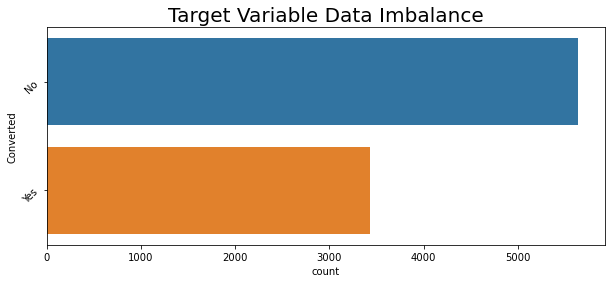

In [34]:
ax = sns.countplot(y=df['Converted'])
plt.yticks([0,1], ['No', 'Yes'], rotation=45)
ax.set_title('Target Variable Data Imbalance', fontsize=20)
ax.figure.set_size_inches(10,4)
plt.show()

**Assessment:**  
- `Converted` is a categorical variable which is also target variable for model training.
- Data imbalance isn't in the favour of the company.

#### Feature: 'Lead Origin'

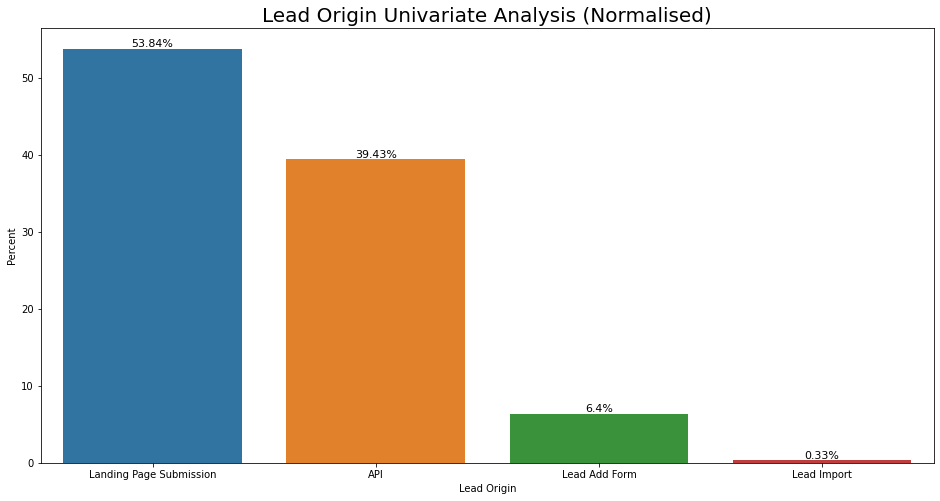

In [35]:
cat_uni_analysis('Lead Origin')
plt.show()

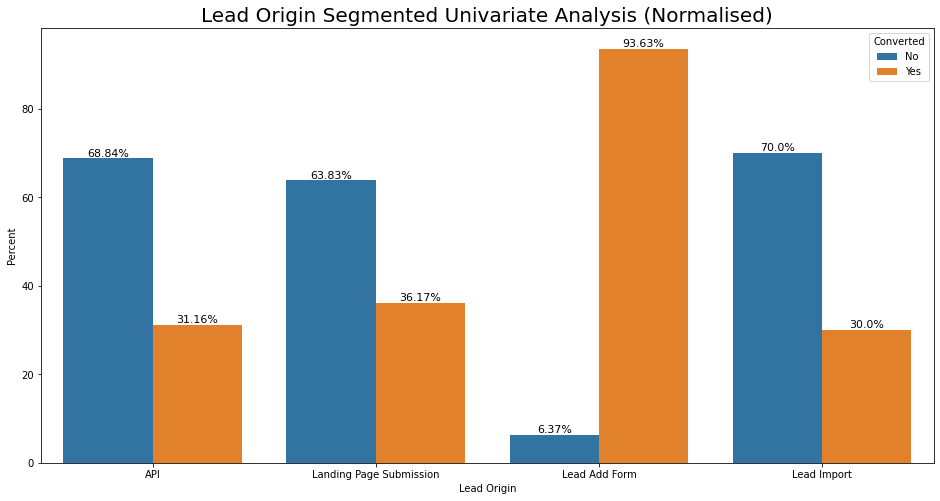

In [36]:
cat_seg_analysis('Lead Origin')
plt.show()

**Assessment:**  
- Landing Page Submission is highest Lead Origin.
- Lead Add Form has better conversion rate.

#### Feature: 'Lead Source'

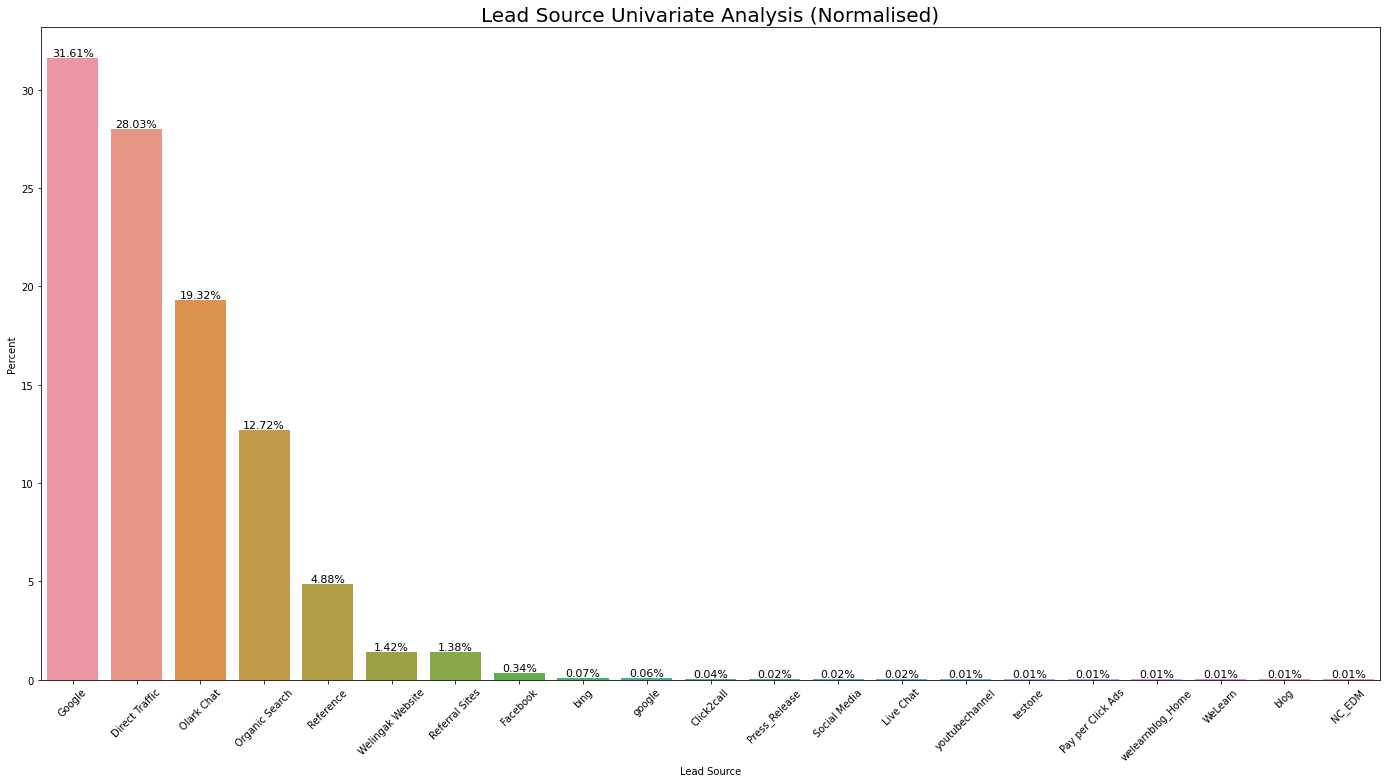

In [37]:
ax = cat_uni_analysis('Lead Source')
ax.figure.set_size_inches(24,12)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

In [38]:
# Fixing spelling issue in data
df['Lead Source'] = df['Lead Source'].replace({'google': 'Google'})

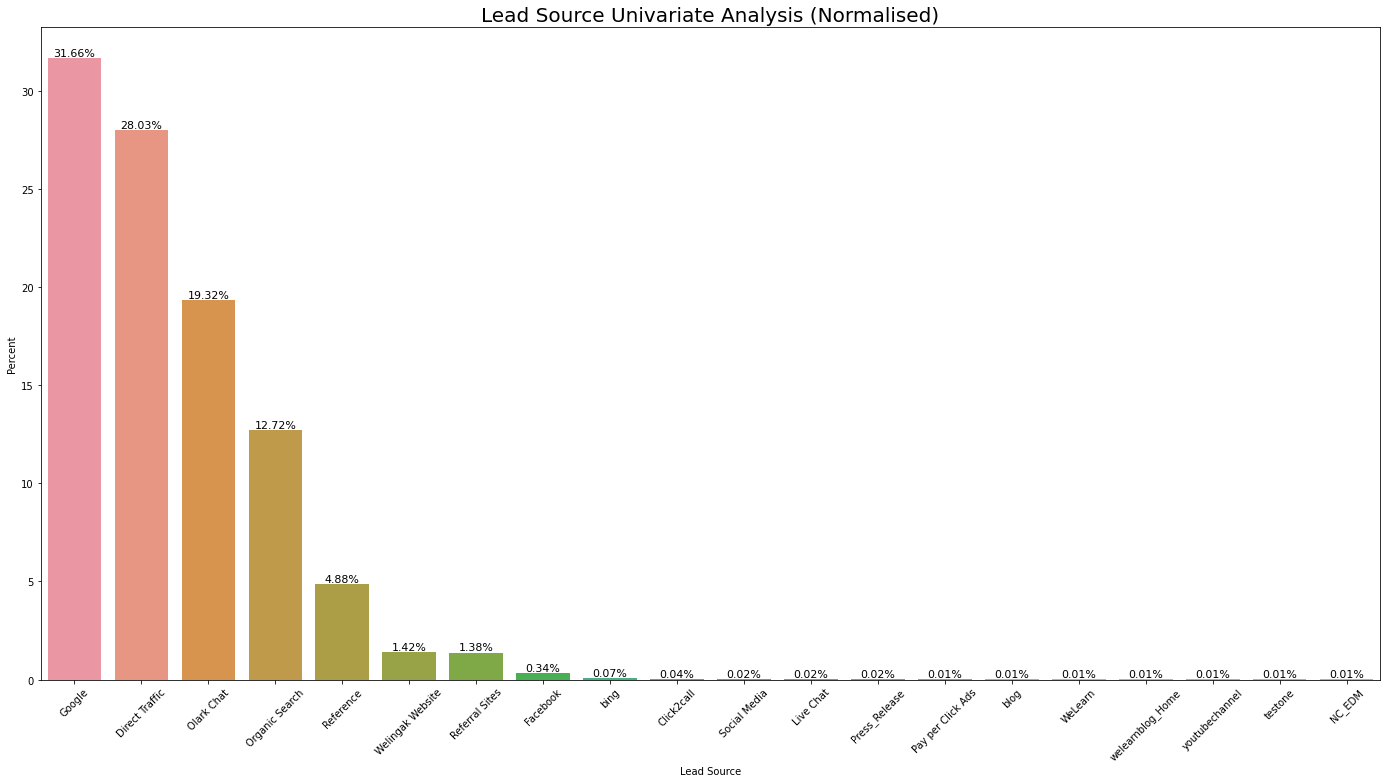

In [39]:
ax = cat_uni_analysis('Lead Source')
ax.figure.set_size_inches(24,12)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

Binning low frequency categories into separate category for stability.

In [40]:
df['Lead Source'] = df['Lead Source'].replace(['Welingak Website', 'Referral Sites', 'Facebook', 'bing', 'Click2call', 'Social Media', 'Live Chat', 'Press_Release', 'Pay per Click Ads', 'blog', 'WeLearn', 'welearnblog_Home', 'youtubechannel', 'testone', 'NC_EDM'], 'Others')

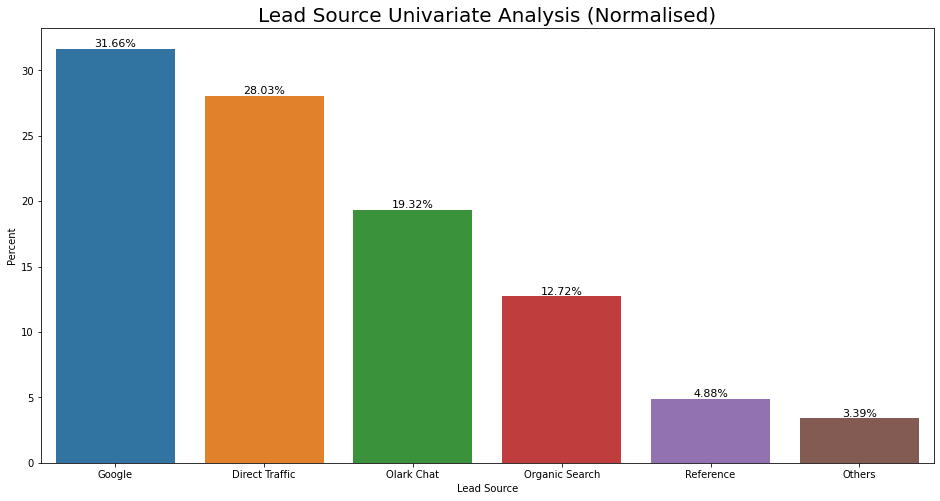

In [41]:
cat_uni_analysis('Lead Source')
plt.show()

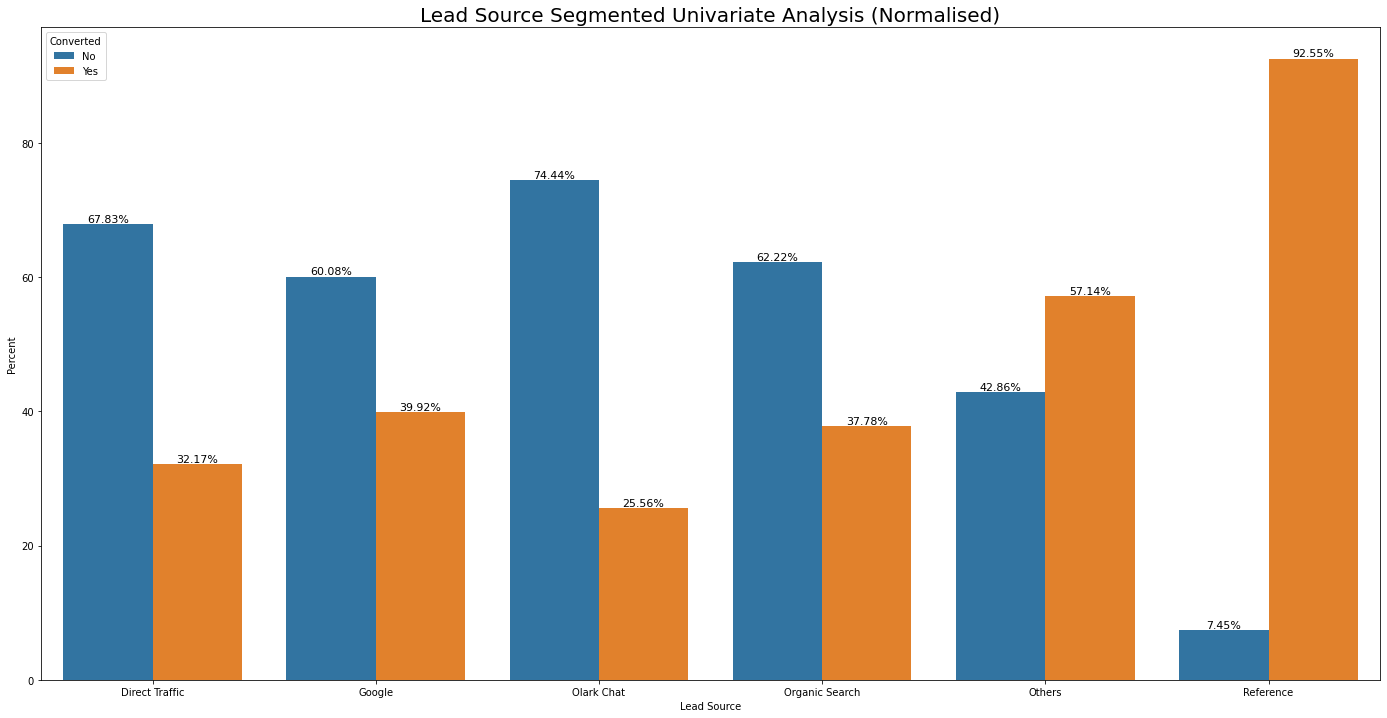

In [42]:
ax = cat_seg_analysis('Lead Source')
ax.figure.set_size_inches(24,12)
plt.show()

**Assessment:**  
- `Google` has highest number of Lead Source.
- `Reference` Lead Source has highest number of conversion rate.

#### Feature: 'Do Not Email'

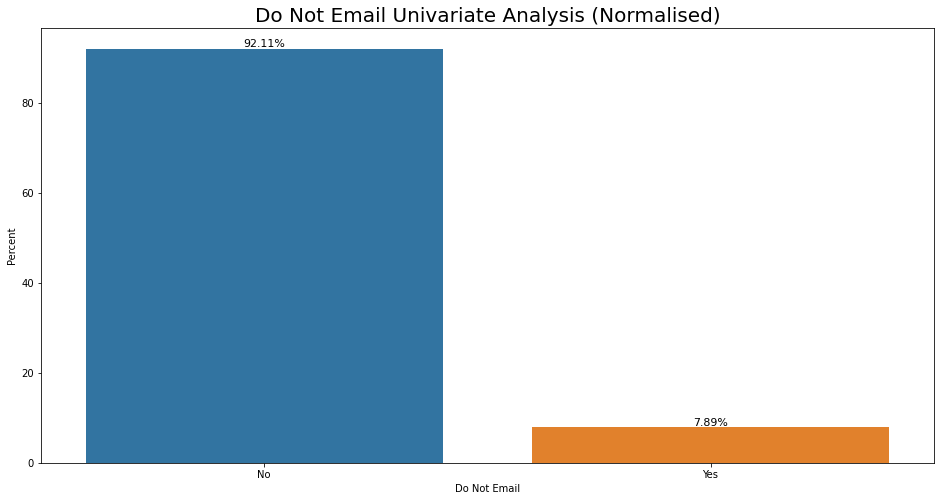

In [43]:
cat_uni_analysis('Do Not Email')
plt.show()

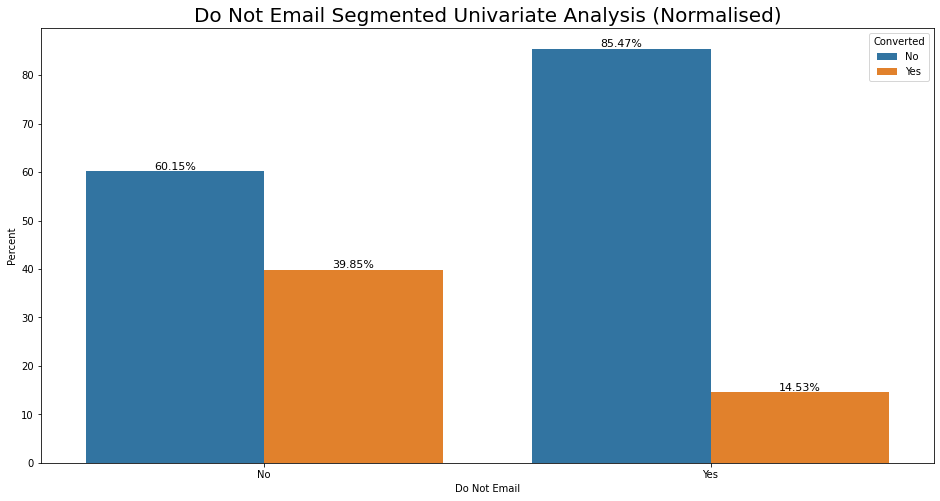

In [44]:
cat_seg_analysis('Do Not Email')
plt.show()

**Assessment:**  
- Most of the customers don't want to get disturbed by the email.
- The customers who don't want to get disturbed by email also converts better.

#### Feature: 'TotalVisits'

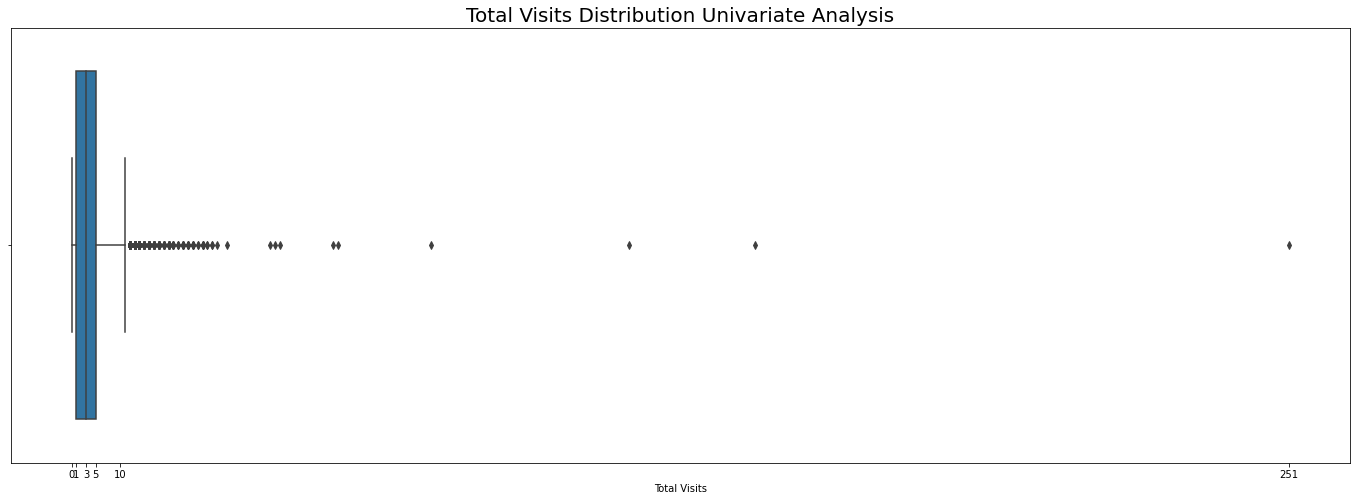

In [45]:
num_uni_box_analysis('TotalVisits', 'Total Visits')
plt.show()

Removing outliers..

In [46]:
df = df[df['TotalVisits'] < 50]

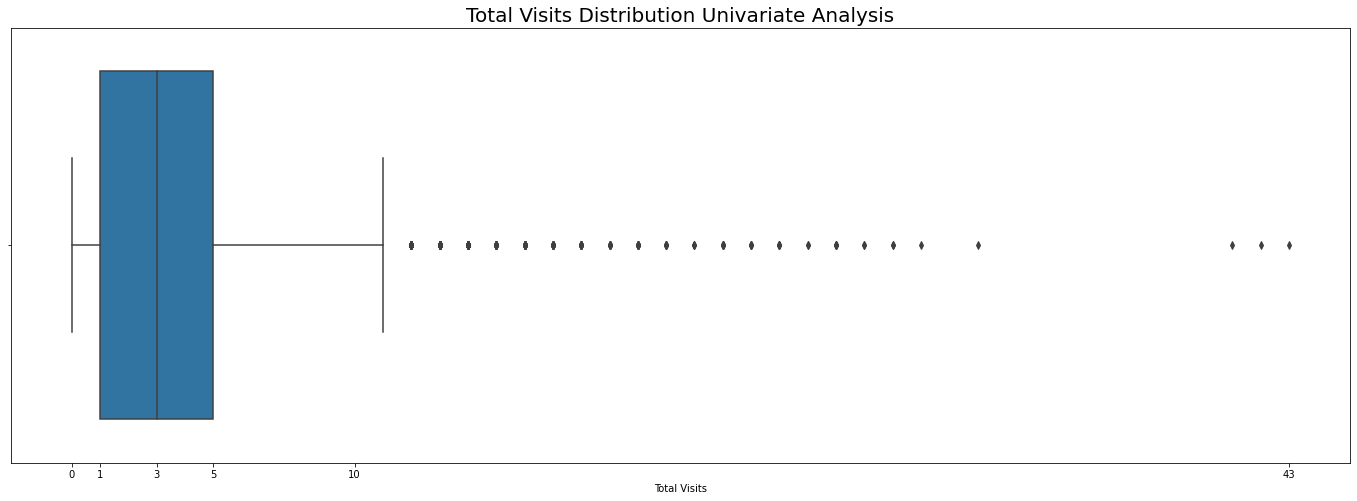

In [47]:
num_uni_box_analysis('TotalVisits', 'Total Visits')
plt.show()

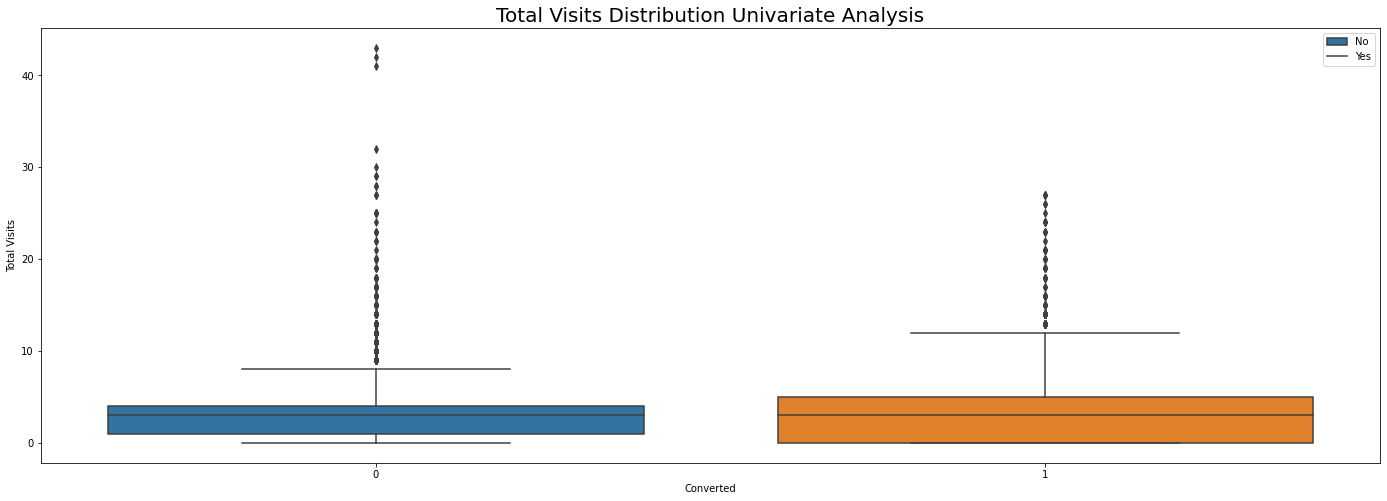

In [48]:
num_uni_box_seg_analysis('TotalVisits', 'Total Visits')
plt.show()

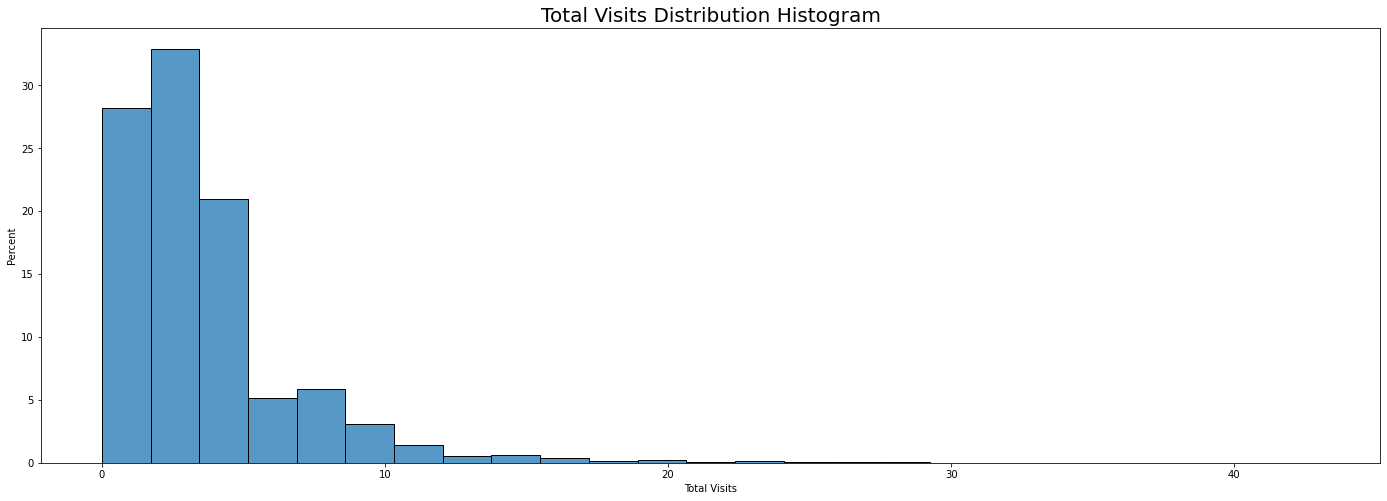

In [49]:
num_uni_hist_analysis('TotalVisits', 'Total Visits')
plt.show()

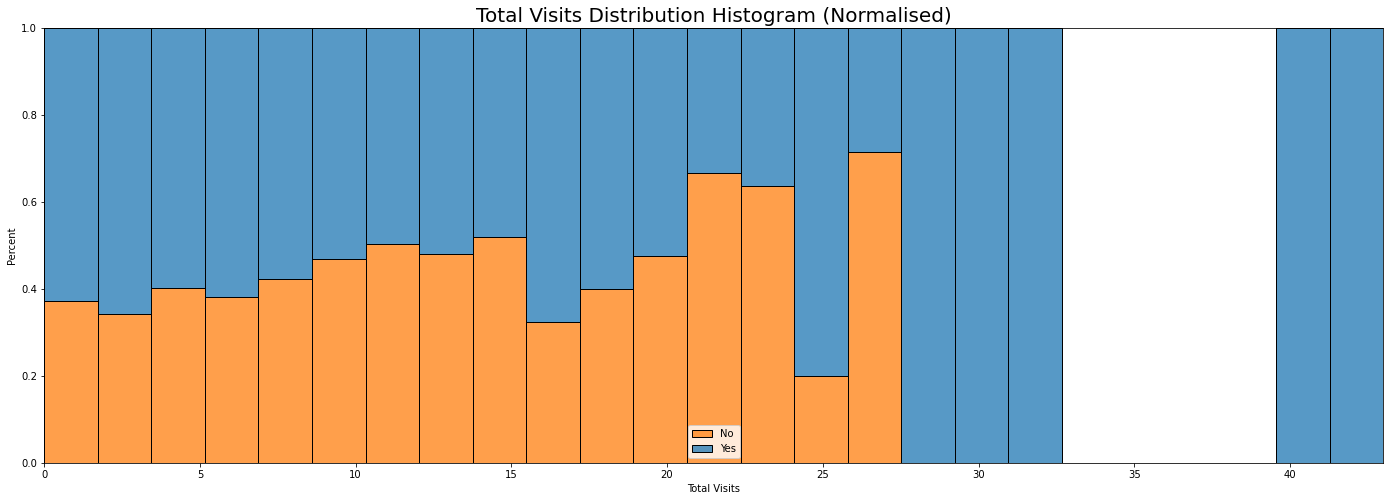

In [50]:
num_uni_hist_seg_analysis('TotalVisits', 'Total Visits')
plt.show()

**Assessment:**  
- `TotalVisits` doesn't say anything significant about conversion. Conversion is higher for outliers that doesn't paint real picture.

#### Feature: 'Total Time Spent on Website'

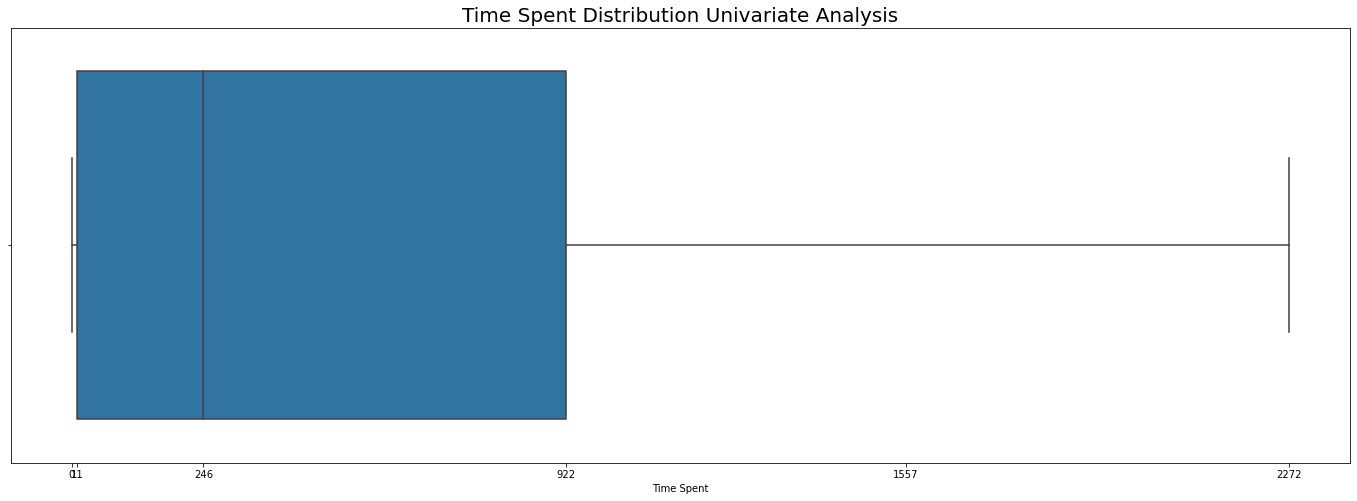

In [51]:
num_uni_box_analysis('Total Time Spent on Website', 'Time Spent')
plt.show()

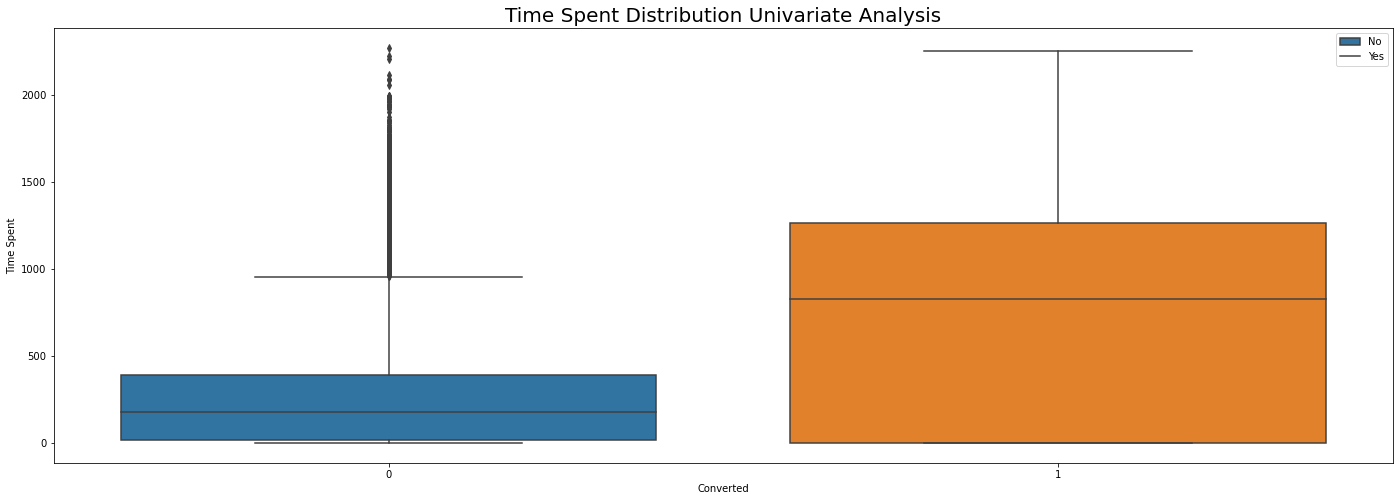

In [52]:
num_uni_box_seg_analysis('Total Time Spent on Website', 'Time Spent')
plt.show()

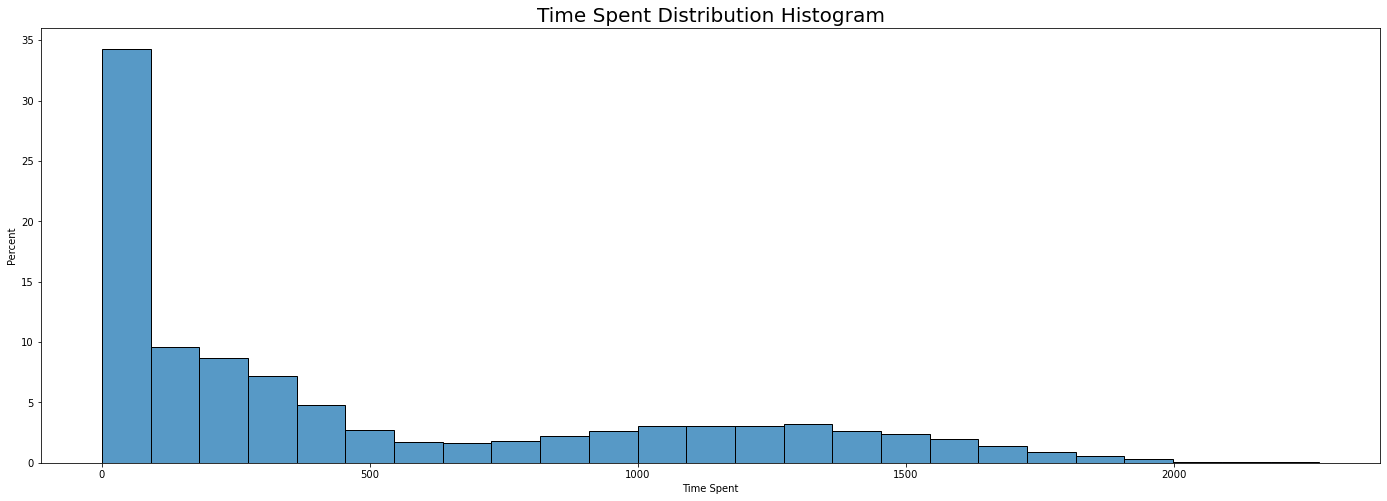

In [53]:
num_uni_hist_analysis('Total Time Spent on Website', 'Time Spent')
plt.show()

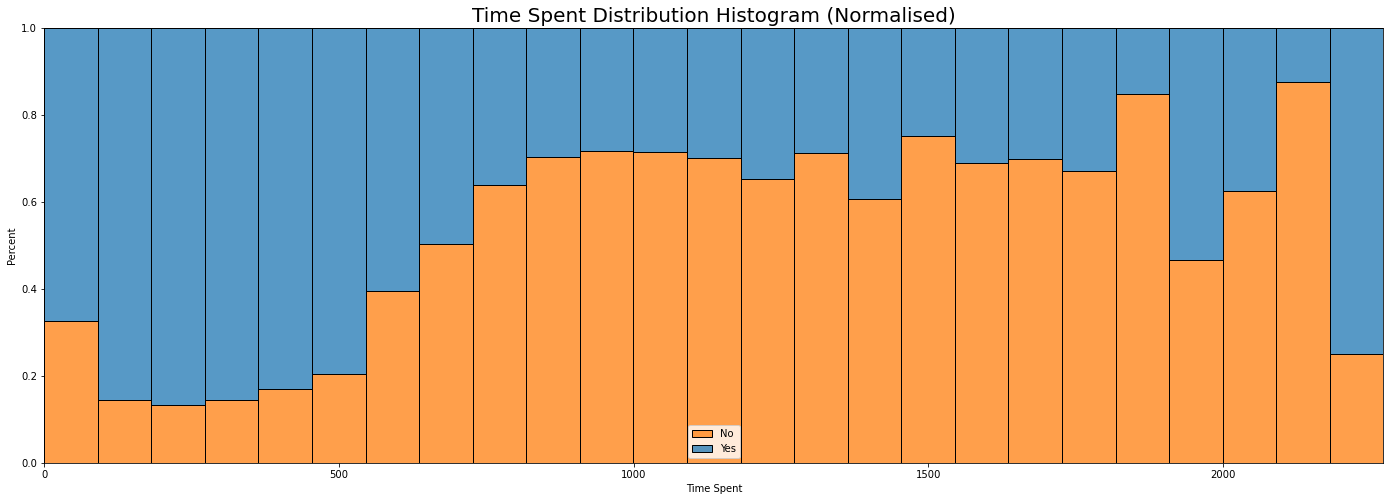

In [54]:
num_uni_hist_seg_analysis('Total Time Spent on Website', 'Time Spent')
plt.show()

**Assessment:**  
- Most customers spend less time on the website.
- Those customers who spend more time on the website convert more.

#### Feature: 'Page Views Per Visit'

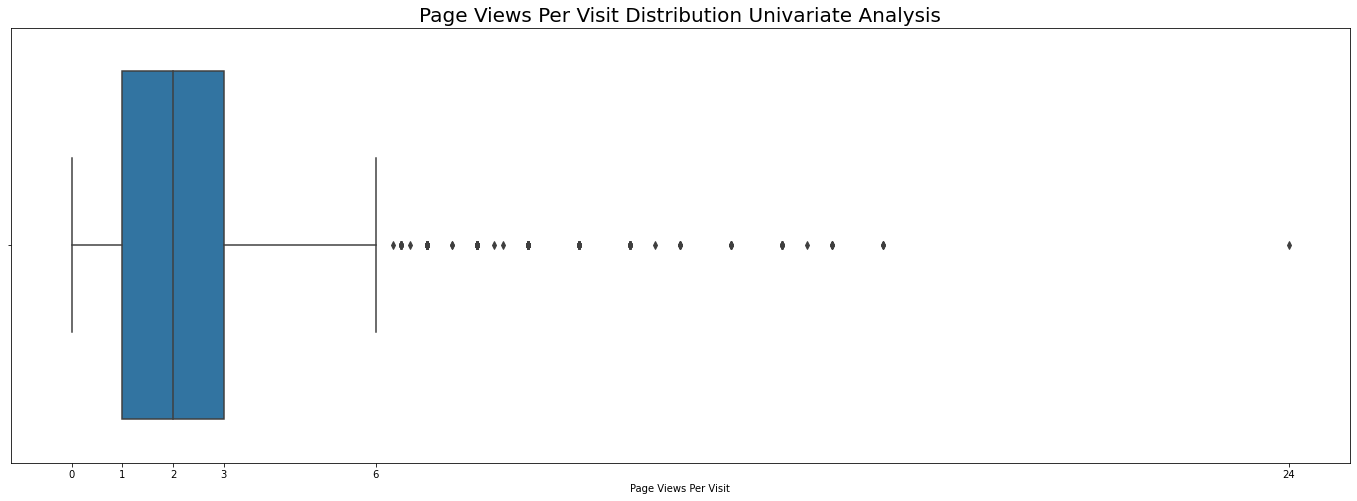

In [55]:
num_uni_box_analysis('Page Views Per Visit')
plt.show()

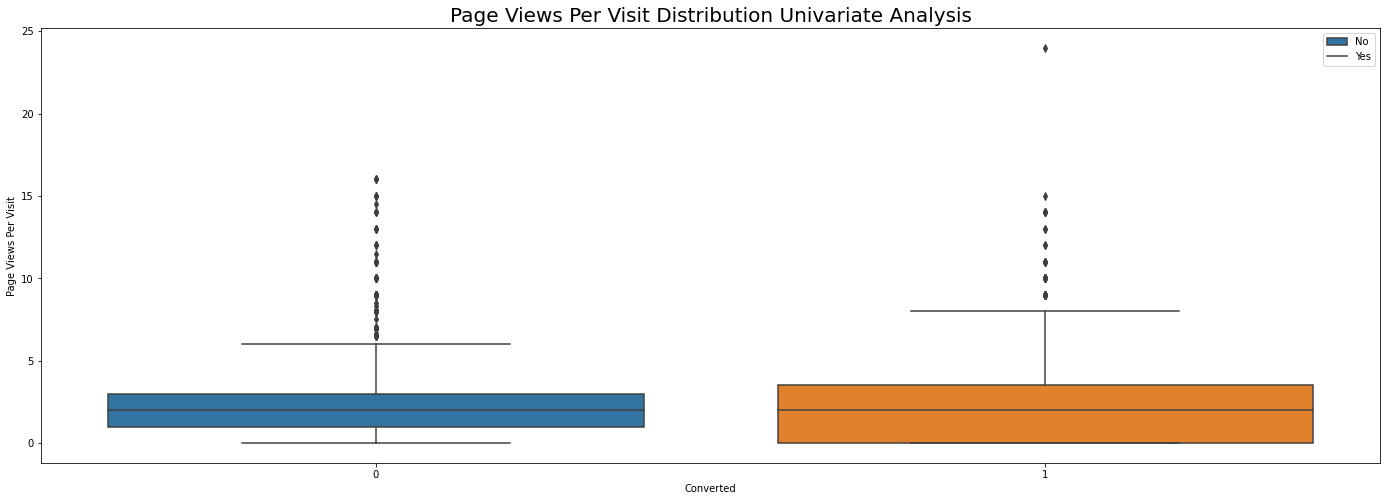

In [56]:
num_uni_box_seg_analysis('Page Views Per Visit')
plt.show()

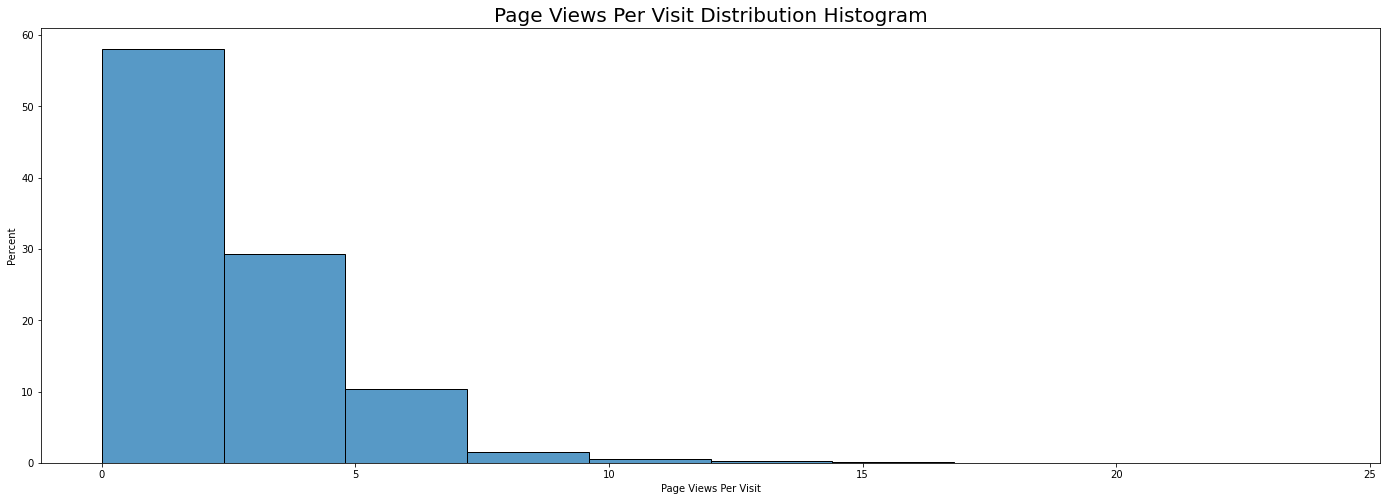

In [57]:
num_uni_hist_analysis('Page Views Per Visit', bins=10)
plt.show()

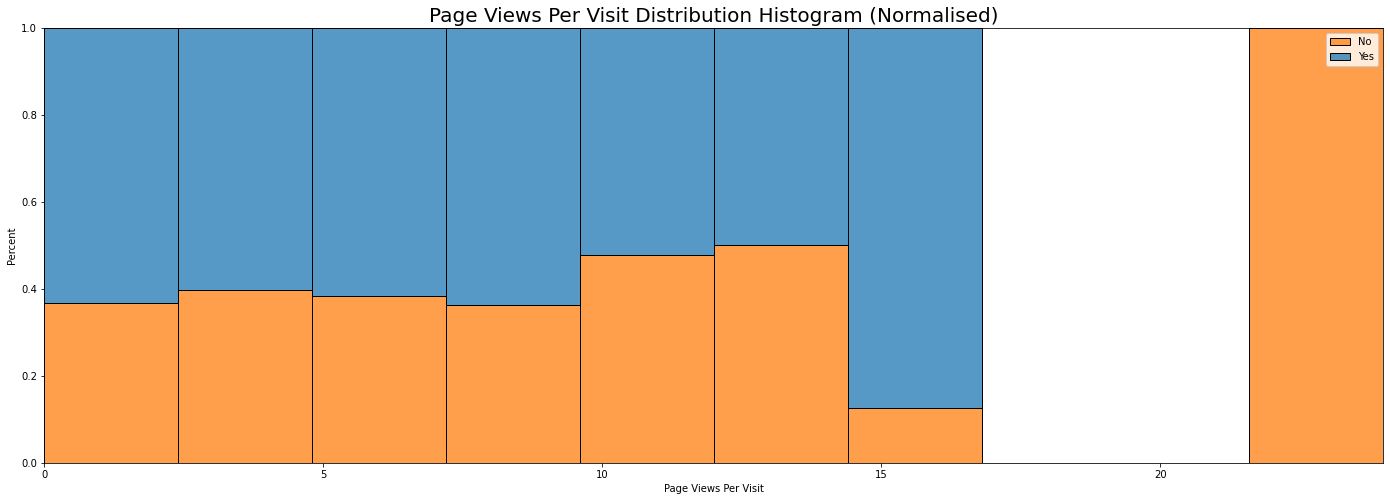

In [58]:
num_uni_hist_seg_analysis('Page Views Per Visit', bins=10)
plt.show()

**Assessment:**  
- `Page Views Per Visit` is less for most customers.
- `Page Views Per Visit` doesn't say anything significant about conversion.

#### Feature: 'Last Activity'

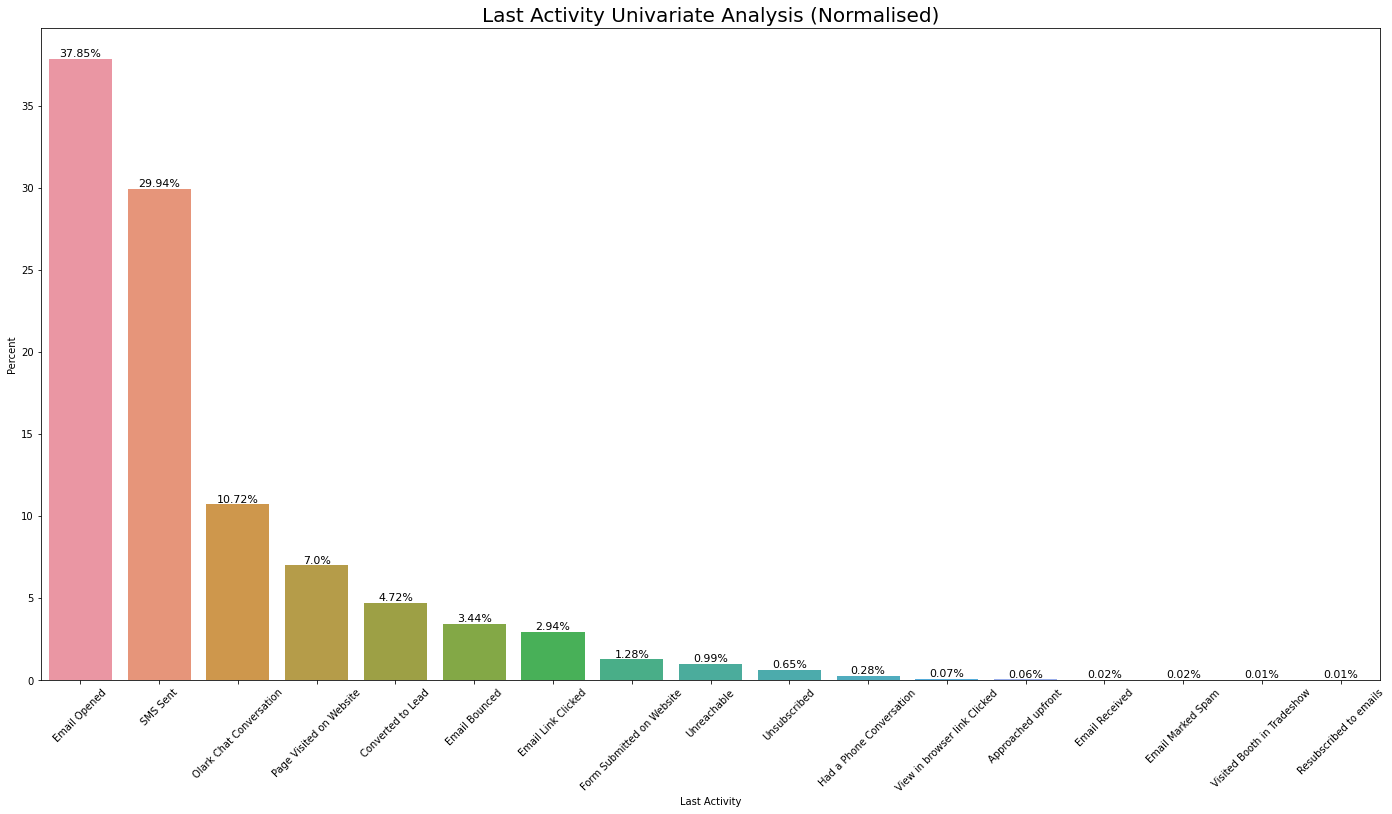

In [59]:
ax = cat_uni_analysis('Last Activity')
ax.figure.set_size_inches(24,12)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

Binning low frequency categories into separate category for stability.

In [60]:
df['Last Activity'] = df['Last Activity'].replace(['Unreachable', 'Unsubscribed', 'Had a Phone Conversation', 'View in browser link Clicked', 'Approached upfront', 'Email Received', 'Email Marked Spam', 'Visited Booth in Tradeshow', 'Resubscribed to emails'], 'Other')

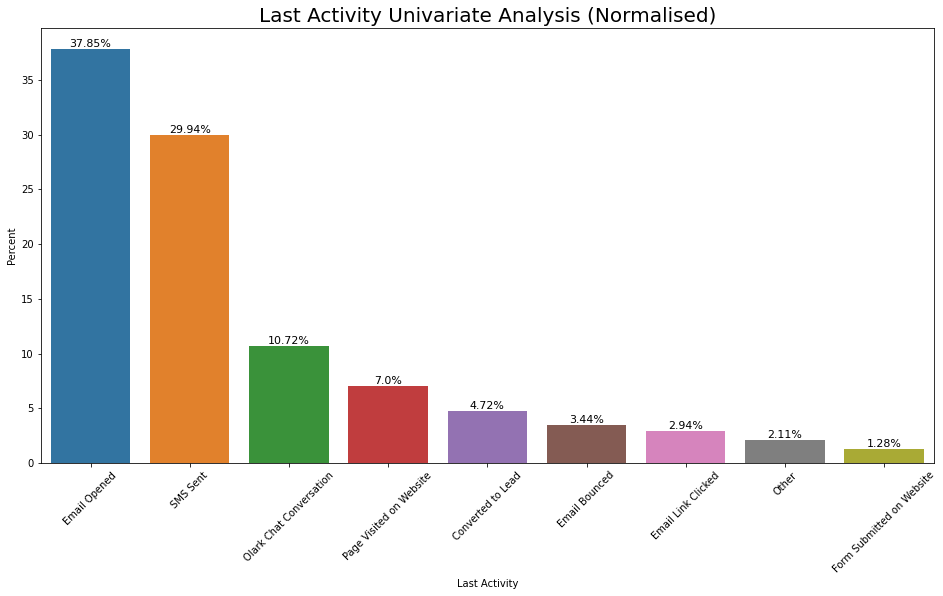

In [61]:
ax = cat_uni_analysis('Last Activity')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

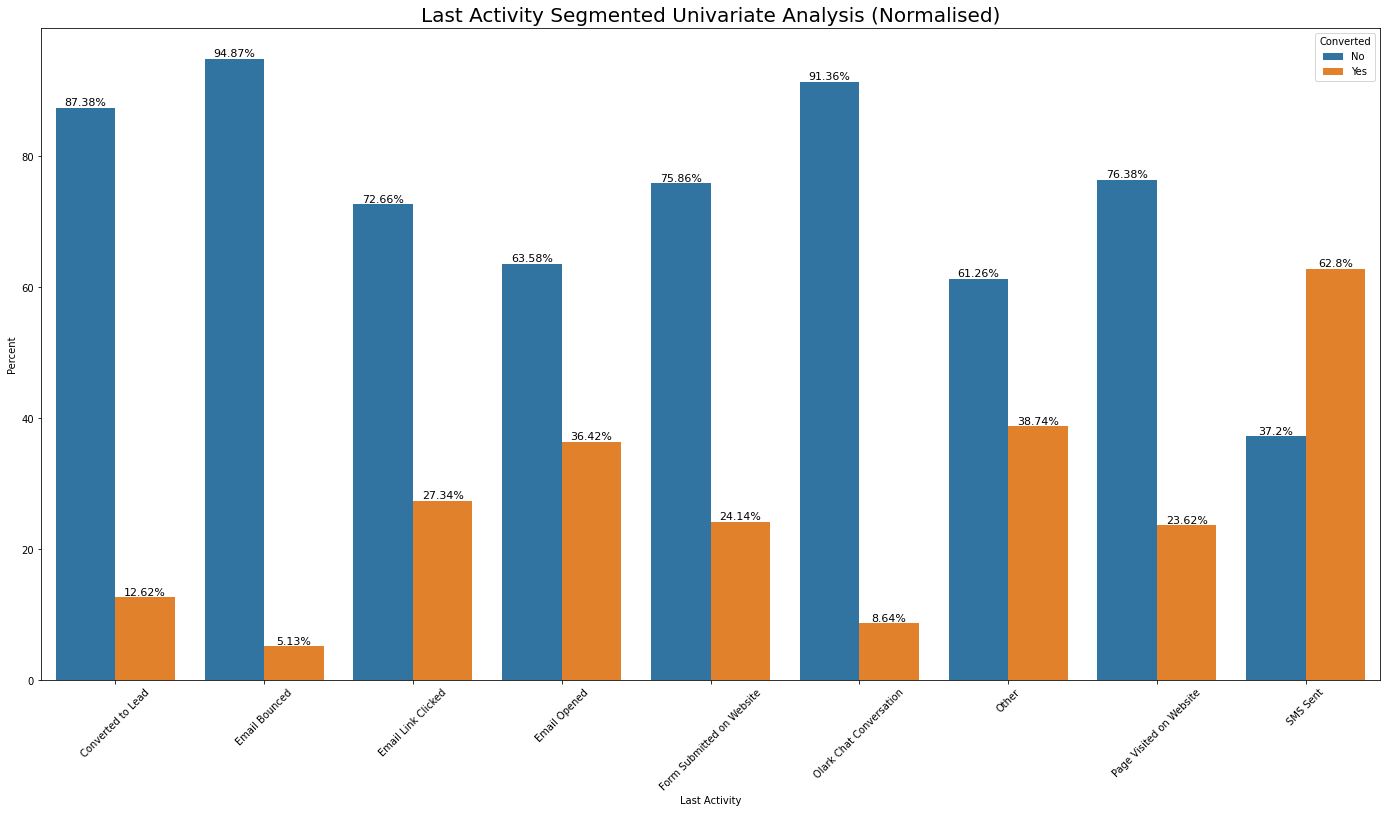

In [62]:
ax = cat_seg_analysis('Last Activity')
ax.figure.set_size_inches(24,12)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

**Assessment:**  
- If `Last Activity` is `SMS Sent`, conversion is highest.

#### Feature: 'Country'

In [63]:
df['Country'].value_counts(normalize=True) * 100

India                   96.835024
United States            0.760918
United Arab Emirates     0.584473
Singapore                0.264667
Saudi Arabia             0.231584
United Kingdom           0.165417
Australia                0.143361
Qatar                    0.110278
Hong Kong                0.077195
Bahrain                  0.077195
Oman                     0.066167
France                   0.066167
unknown                  0.055139
South Africa             0.044111
Nigeria                  0.044111
Germany                  0.044111
Kuwait                   0.044111
Canada                   0.044111
Sweden                   0.033083
China                    0.022056
Asia/Pacific Region      0.022056
Uganda                   0.022056
Bangladesh               0.022056
Italy                    0.022056
Belgium                  0.022056
Netherlands              0.022056
Ghana                    0.022056
Philippines              0.022056
Russia                   0.011028
Switzerland   

Binning all non-Indian categories into separate feature for stability.

In [64]:
df['Country'] = df['Country'].apply(lambda x: 'Others' if x != 'India' else 'India')

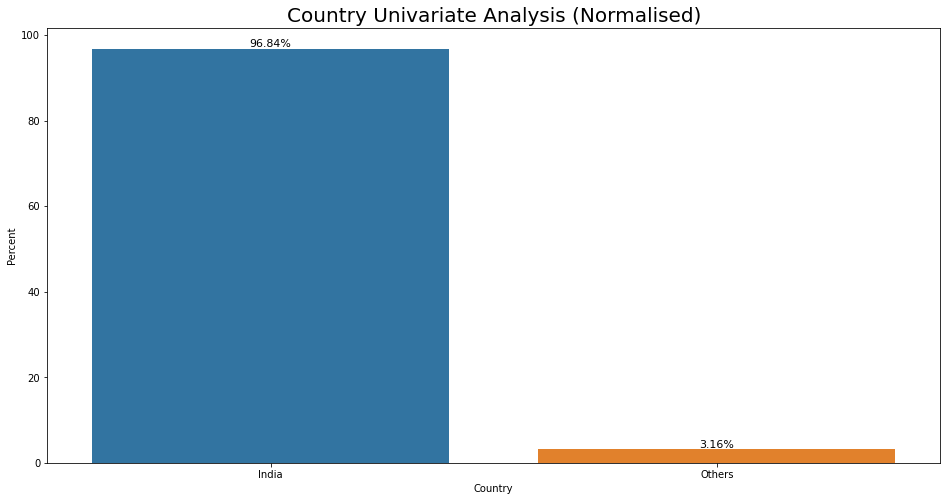

In [65]:
cat_uni_analysis('Country')
plt.show()

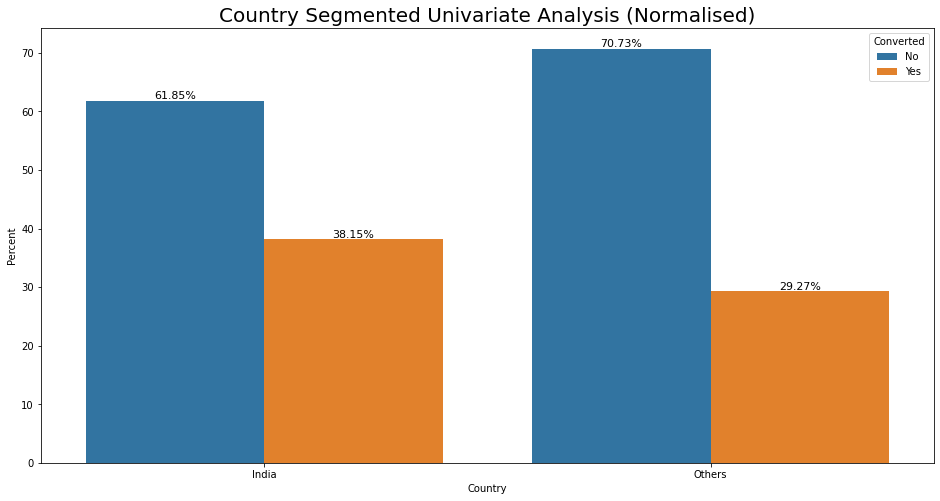

In [66]:
cat_seg_analysis('Country')
plt.show()

**Assessment:**  
- Most of the customers belong from India.
- Conversion rate of Indians is little bit better.

#### Feature: 'Specialization'

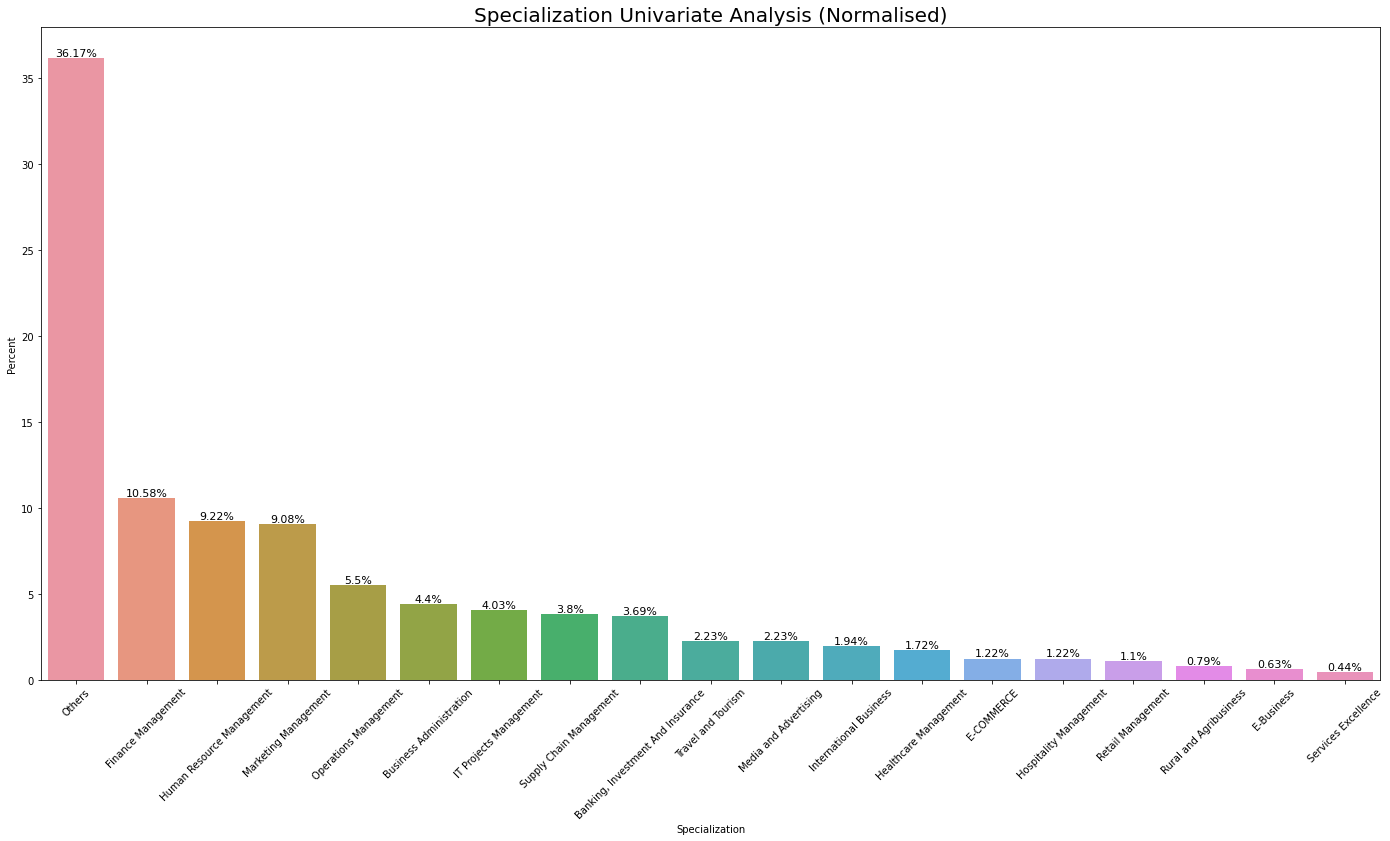

In [67]:
ax = cat_uni_analysis('Specialization')
ax.figure.set_size_inches(24,12)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

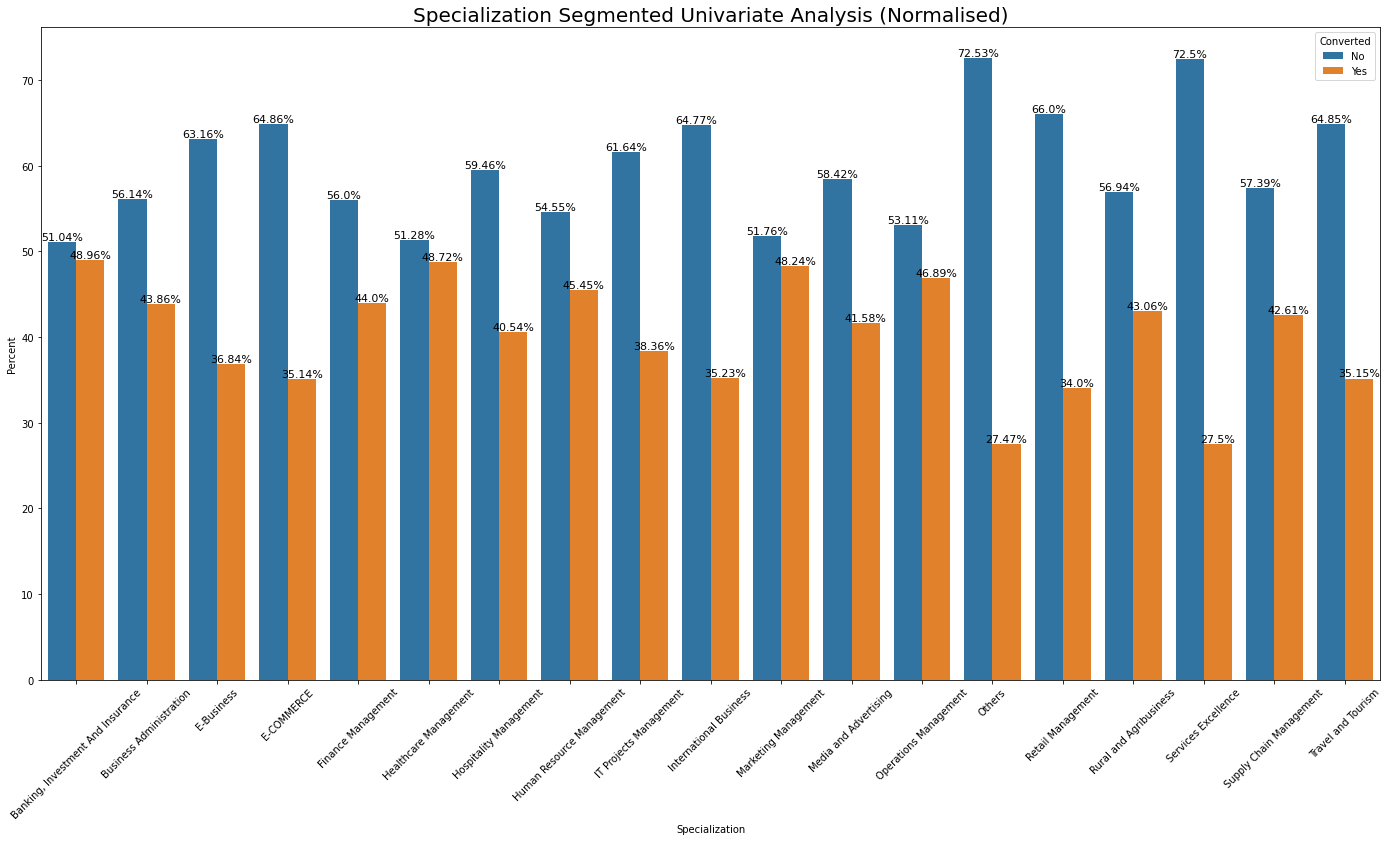

In [68]:
ax = cat_seg_analysis('Specialization')
ax.figure.set_size_inches(24,12)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

**Assessment:**  
- Customers in Banking, Investment And Insurance specialization convert most closely followed by customers in Healthcare Management & Marketing Management.

#### Feature: 'What is your current occupation'

Renaming the feature name to `Occupation`.

In [69]:
df.rename(columns={'What is your current occupation': 'Occupation'}, inplace=True)

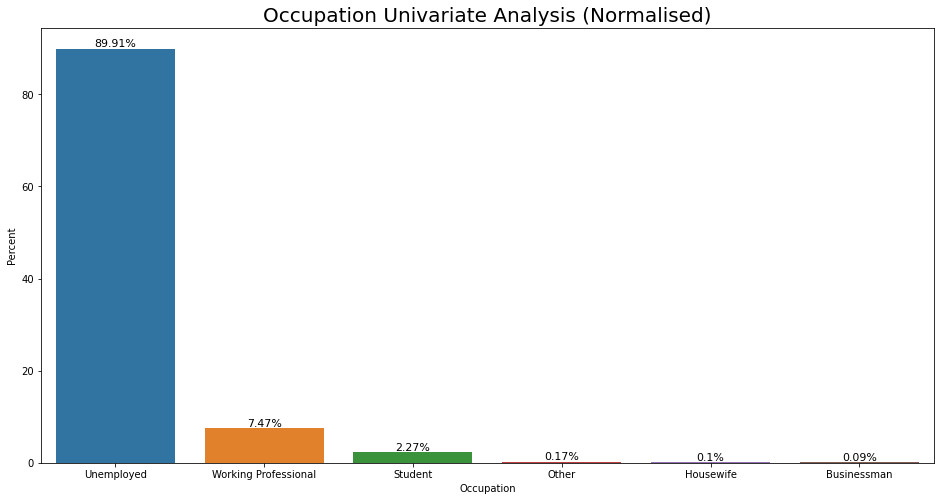

In [70]:
cat_uni_analysis('Occupation')
plt.show()

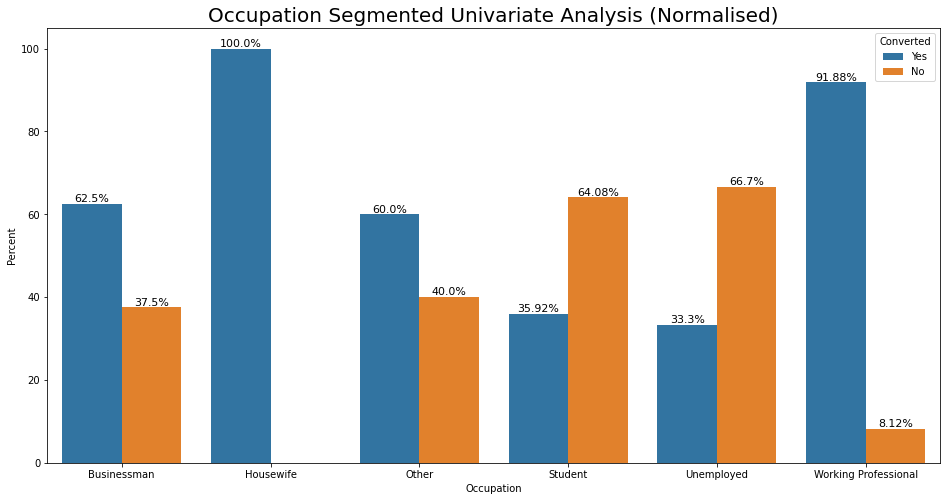

In [71]:
cat_seg_analysis('Occupation')
plt.show()

**Assessment:**  
- Most of the customers are unemployed.
- `Unemployed` & `Student` both convert most.

#### Feature: 'Tags'

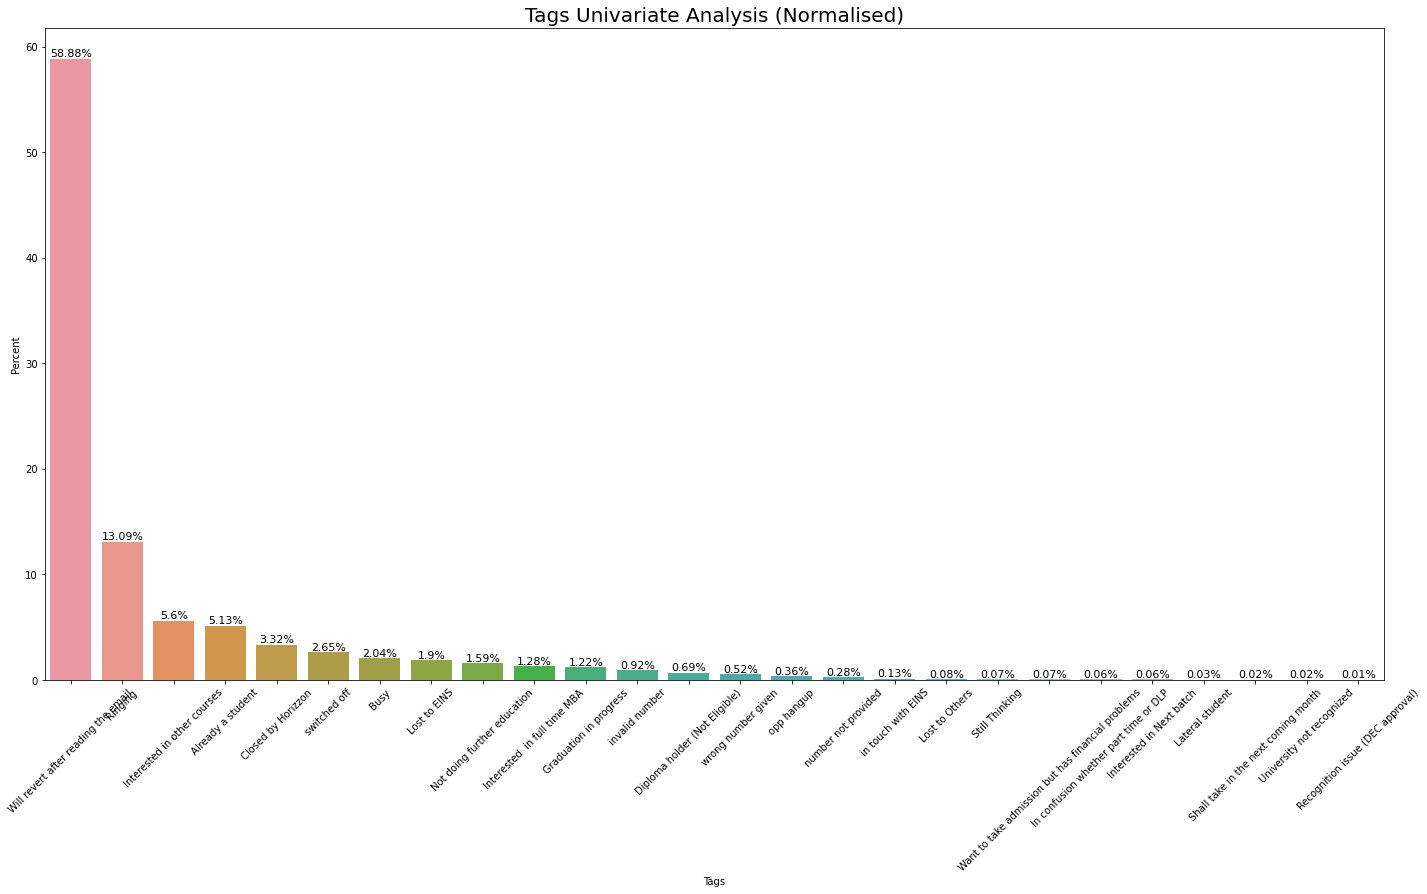

In [72]:
ax = cat_uni_analysis('Tags')
ax.figure.set_size_inches(24,12)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

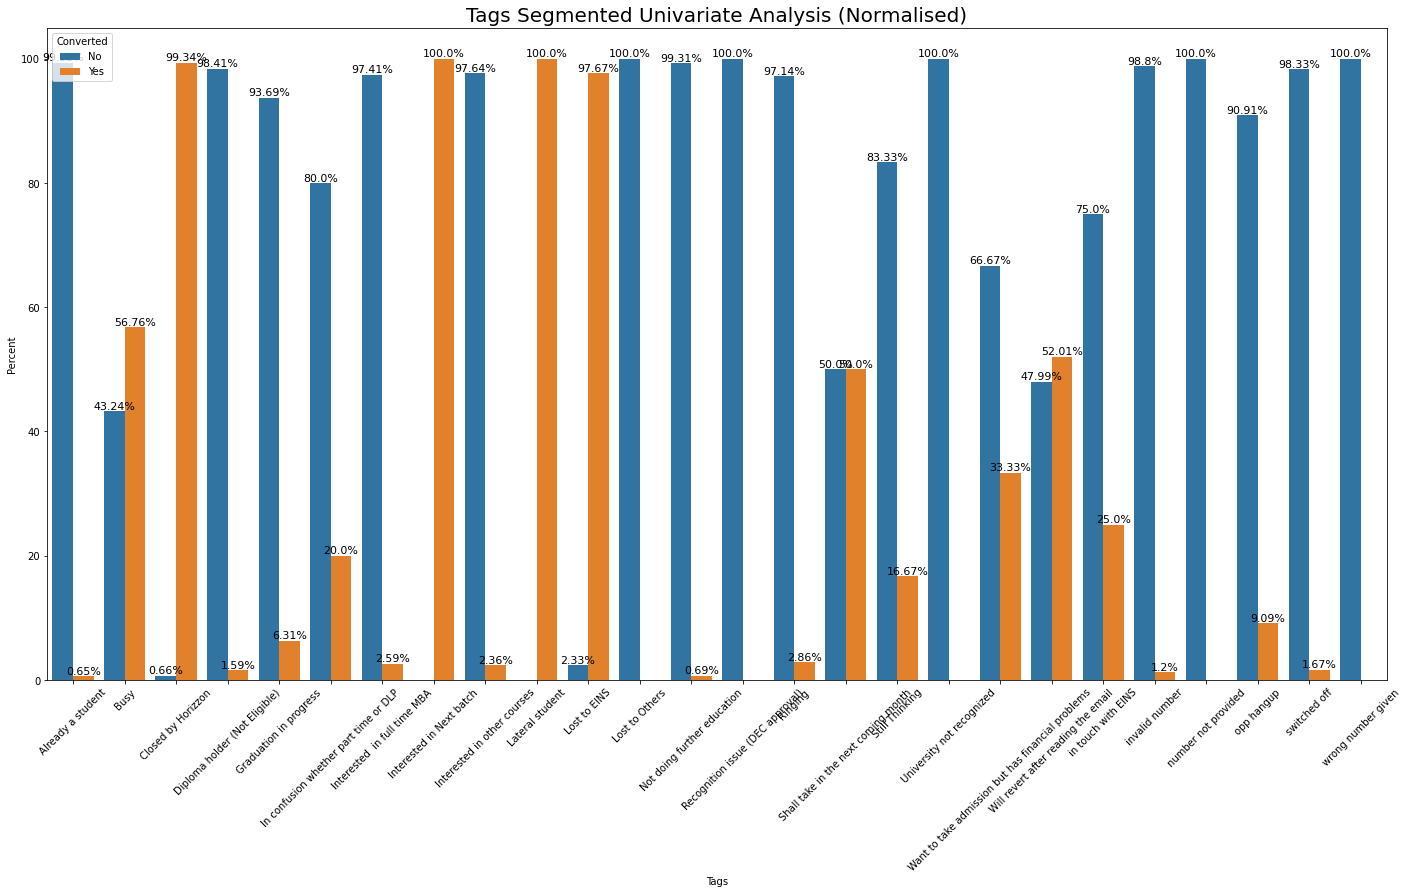

In [73]:
ax = cat_seg_analysis('Tags')
ax.figure.set_size_inches(24,12)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

#### Feature: 'City'

In [74]:
df['City'].value_counts(normalize=True) * 100

Mumbai                         73.753860
Thane & Outskirts               8.204676
Other Cities                    8.149537
Other Cities of Maharashtra     4.918394
Other Metro Cities              4.157477
Tier II Cities                  0.816056
Name: City, dtype: float64

In [75]:
df[(df['Country'] != 'India') & (df['City'] == 'Mumbai')][['Country', 'City']].head()

,Country,City
87,Others,Mumbai
103,Others,Mumbai
243,Others,Mumbai
425,Others,Mumbai
445,Others,Mumbai


There are issues with data. The `Others` country shouldn't have `Mumbai` city. Fixing.

In [76]:
df['City'] = df.apply(lambda x: 'Other Cities' if ((x['Country'] == 'Others') & (x['City'] in ['Mumbai', 'Thane & Outskirts', 'Other Cities of Maharashtra'])) else x['City'], axis=1)

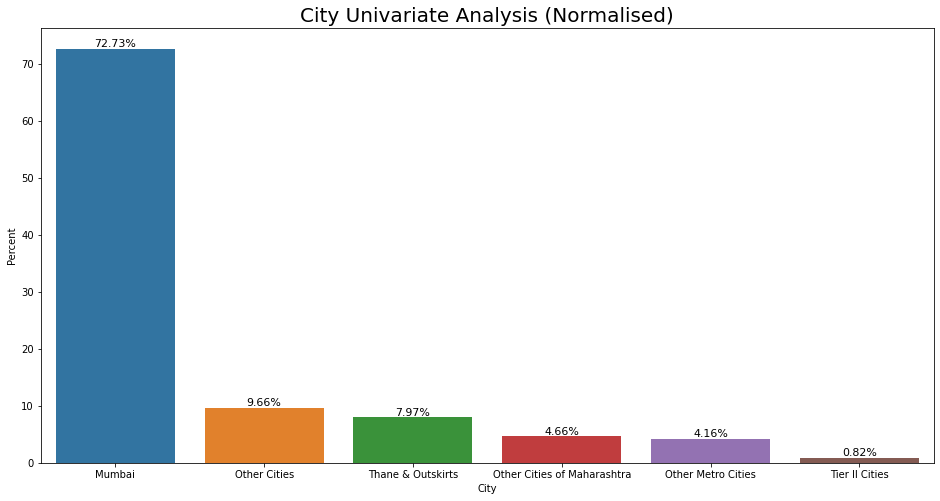

In [77]:
cat_uni_analysis('City')
plt.show()

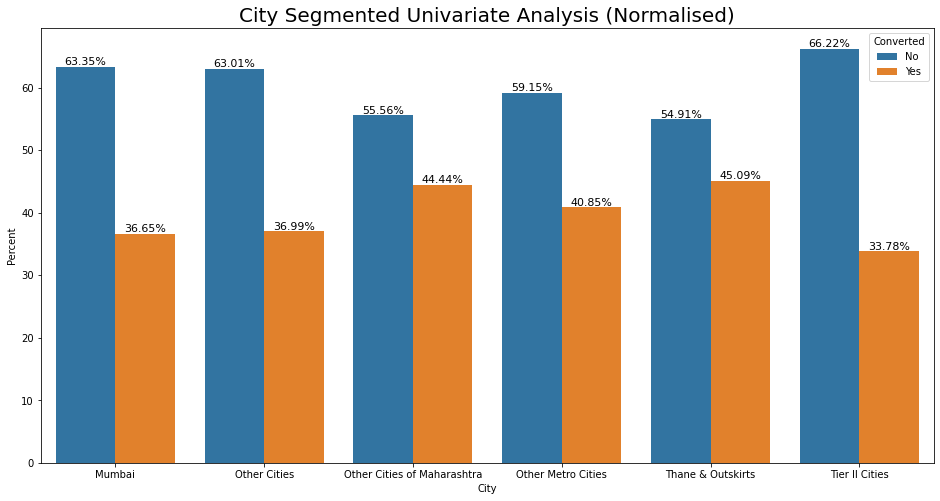

In [78]:
cat_seg_analysis('City')
plt.show()

**Assessment:**  
- Most of the customers are from `Mumbai`.
- Customers from `Thane & Outskirts` and `Other Cities of Maharashtra` convert most.

#### Feature: 'A free copy of Mastering The Interview'

Renaming the feature name to `Gift`.

In [79]:
df.rename(columns={'A free copy of Mastering The Interview': 'Gift'}, inplace=True)

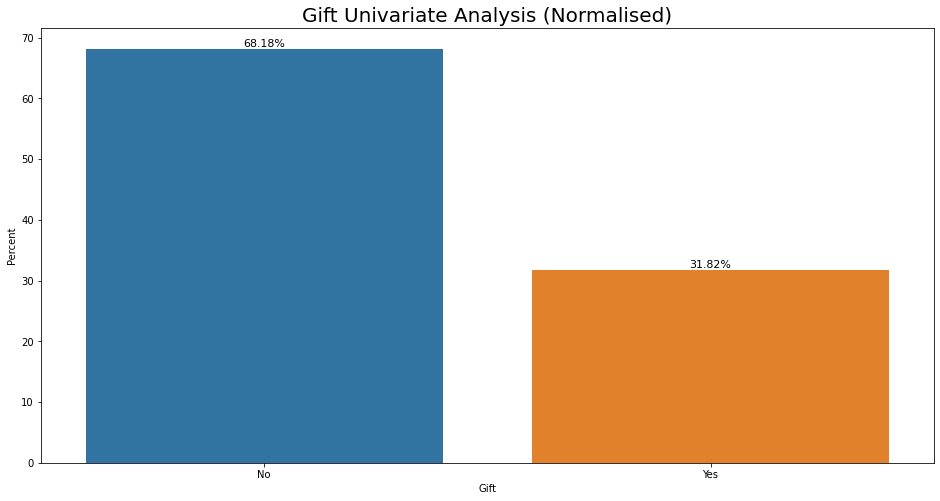

In [80]:
cat_uni_analysis('Gift')
plt.show()

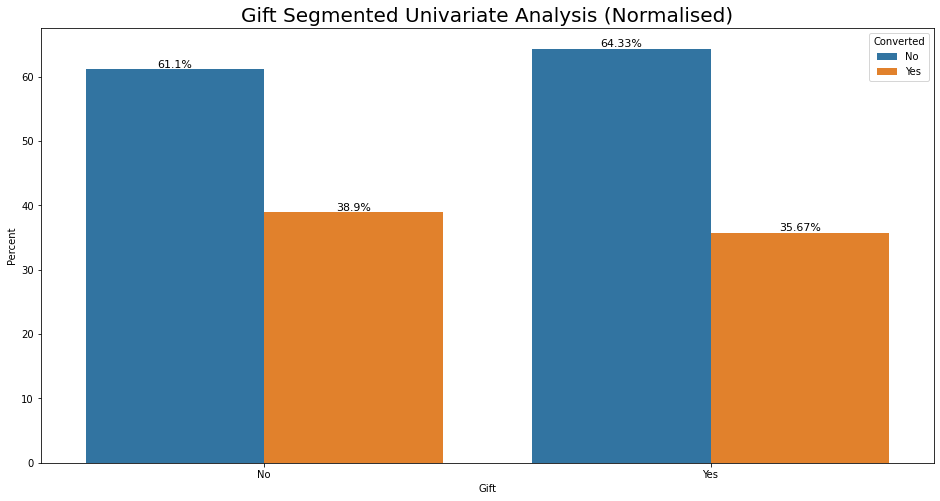

In [81]:
cat_seg_analysis('Gift')
plt.show()

**Assessment:**  
- Most customers don't want free copy of 'Mastering the Interview'.
- This choice doesn't significantly affect conversion rate.

### Bivariate Analysis

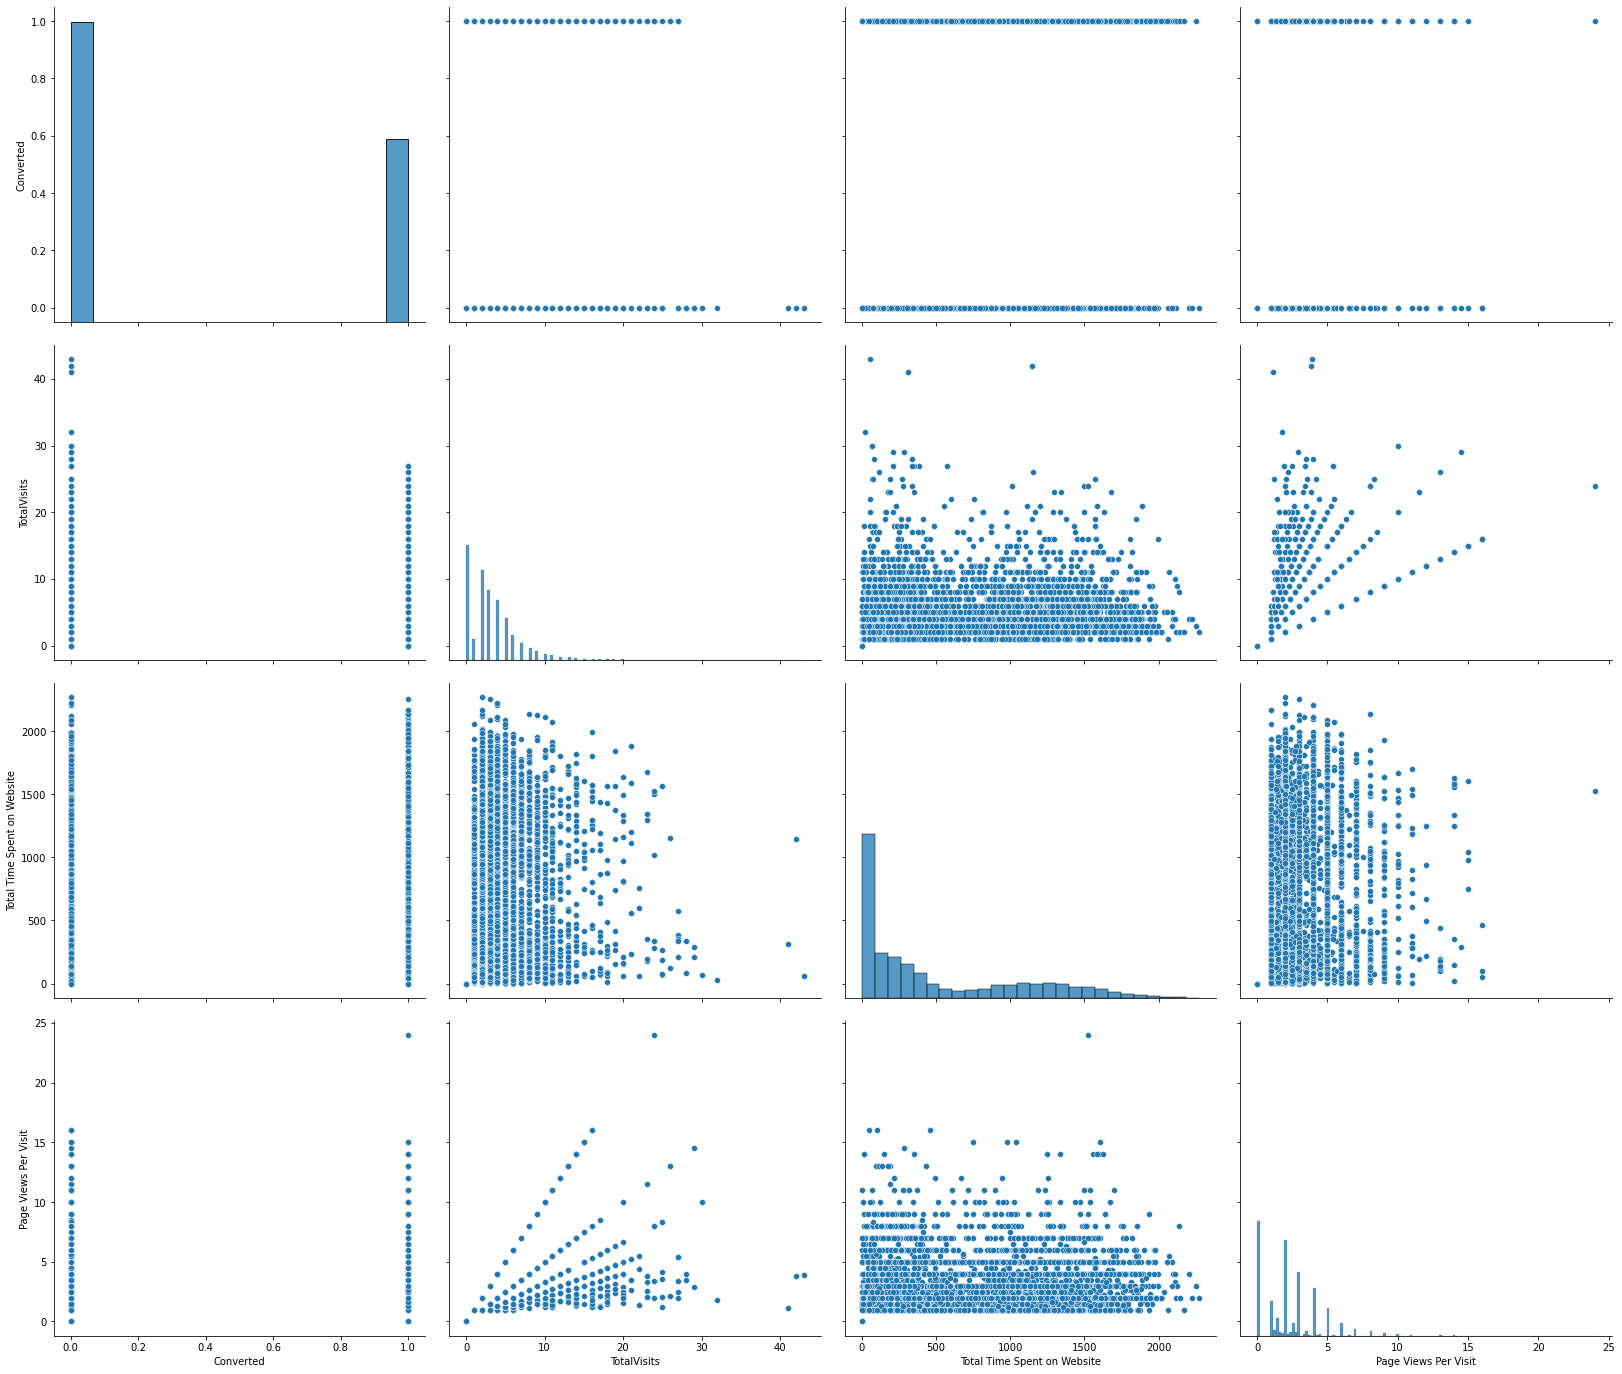

In [82]:
ax = sns.pairplot(df)
ax.figure.set_size_inches(24,20)

#### Correlation

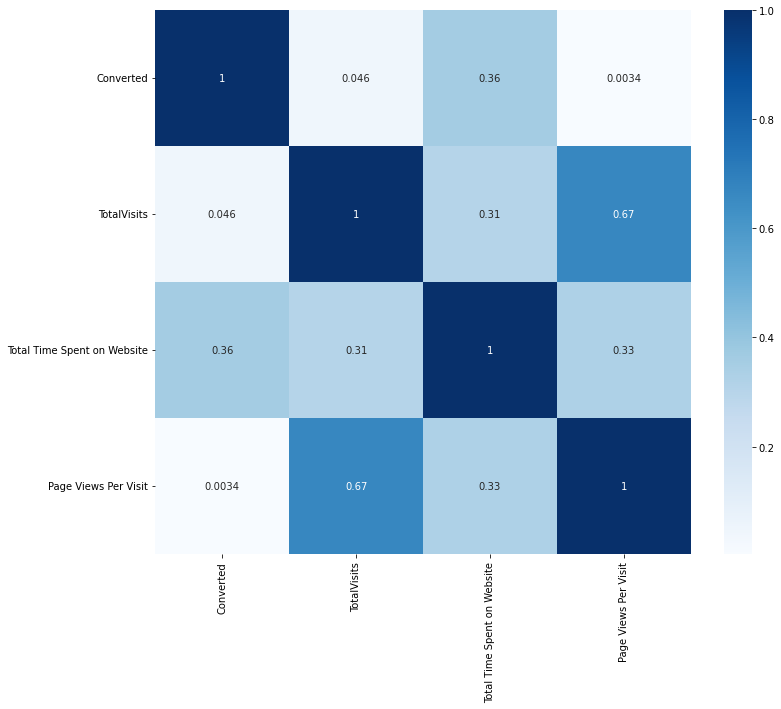

In [83]:
# Heatmap
ax = sns.heatmap(df.corr(), cmap='Blues', annot=True)
ax.figure.set_size_inches(12,10)
plt.show()

**Assessment:**  
- `Converted` is moderately correlated with `Total Time Spent on Website`.

## Data Preparation

### Dummy Variables Creation

In [84]:
cat_vars = ['Lead Origin', 'Lead Source', 'Do Not Email','Last Activity', 'Country', 'Specialization', 'Occupation', 'Tags', 'City', 'Gift']
cat_dum = pd.get_dummies(df[cat_vars], drop_first=True)
df.drop(columns=cat_vars, inplace=True)
df = pd.concat([df, cat_dum], axis=1)
df.columns

Index(['Converted', 'TotalVisits', 'Total Time Spent on Website',
       'Page Views Per Visit', 'Lead Origin_Landing Page Submission',
       'Lead Origin_Lead Add Form', 'Lead Origin_Lead Import',
       'Lead Source_Google', 'Lead Source_Olark Chat',
       'Lead Source_Organic Search', 'Lead Source_Others',
       'Lead Source_Reference', 'Do Not Email_Yes',
       'Last Activity_Email Bounced', 'Last Activity_Email Link Clicked',
       'Last Activity_Email Opened', 'Last Activity_Form Submitted on Website',
       'Last Activity_Olark Chat Conversation', 'Last Activity_Other',
       'Last Activity_Page Visited on Website', 'Last Activity_SMS Sent',
       'Country_Others', 'Specialization_Business Administration',
       'Specialization_E-Business', 'Specialization_E-COMMERCE',
       'Specialization_Finance Management',
       'Specialization_Healthcare Management',
       'Specialization_Hospitality Management',
       'Specialization_Human Resource Management',
       'Specia

In [85]:
df.shape

(9068, 76)

### Train-Test Split

In [86]:
df_train, df_test = train_test_split(df, train_size=0.7, random_state=100)

In [87]:
df_train.shape

(6347, 76)

In [88]:
df_test.shape

(2721, 76)

### Feature Scaling on Training Data

In [89]:
# Learn Min & Max values
num_vars = ['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']
scaler = MinMaxScaler()
scaler.fit(df_train[num_vars])

MinMaxScaler()

In [90]:
# Scale
df_train[num_vars] = scaler.transform(df_train[num_vars])
df_train.head()

,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,...,Tags_number not provided,Tags_opp hangup,Tags_switched off,Tags_wrong number given,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Thane & Outskirts,City_Tier II Cities,Gift_Yes
3050,0,0.186047,0.025528,0.111250,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6708,1,0.000000,0.000000,0.000000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1248,0,0.046512,0.658891,0.083333,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1429,0,0.046512,0.566901,0.083333,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2178,0,0.116279,0.041373,0.208333,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Model Training

In [91]:
# Creating function to easily calculate VIF
def calculate_vif(x_df):
  vif_df = pd.DataFrame({'Feature': x_df.columns, 'VIF': [ variance_inflation_factor(x_df.values, i) for i in range(x_df.shape[1])]})
  vif_df['VIF'] = vif_df['VIF'].round(2)
  vif_df = vif_df.sort_values(by='VIF', ascending=False)
  return vif_df

In [92]:
# Creating function to easily train models
def train_model(y_df, x_df):
  # Preparing for intercept
  x_df_sm = sm.add_constant(x_df)
  # Training model
  lr = sm.GLM(y_df, x_df_sm, sm.families.Binomial())
  lr_model = lr.fit()
  return lr_model

In [93]:
# Extract Target Variable
y_train = df_train.pop('Converted')
X_train = df_train

In [94]:
# Creating function to easily select features
def auto_select_features(n, x_df=X_train):
  logreg = LogisticRegression(max_iter=1000)
  selector = RFE(logreg, n_features_to_select=n)
  selector = selector.fit(x_df, y_train)
  top_features_df = pd.DataFrame({'Feature': x_df.columns, 'Selected': selector.support_, 'Rank': selector.ranking_})
  selected_vars = top_features_df[top_features_df['Selected'] == True]['Feature'].to_list()
  return selected_vars

In [95]:
# Creating function to easily evaluate performance of model over multiple probability cutoffs
def model_performance(model, x_df, y_df=y_train):
  prob = [float(x)/10 for x in range(10)]

  y_final = y_df.to_frame()
  x_df_sm = sm.add_constant(x_df)
  y_final['Conversion_Prob'] = model.predict(x_df_sm)

  for i in prob:
    y_final[i] = y_final['Conversion_Prob'].map(lambda x: 1 if x > i else 0)

  performance_df = pd.DataFrame( columns = ['probability_cutoff','accuracy','sensitivity','specificity'])
  for i in prob:
    cm = confusion_matrix(y_final['Converted'], y_final[i])
    total=sum(sum(cm))
    accuracy = (cm[0,0]+cm[1,1])/total
    sensitivity = cm[1,1]/(cm[1,0]+cm[1,1])
    specificity = cm[0,0]/(cm[0,0]+cm[0,1])
    performance_df.loc[i] =[ i ,accuracy,sensitivity,specificity]
  return performance_df

In [96]:
# Creating function to draw ROC curve
def roc(model, x_df, y_df=y_train):
    y_final = y_df.to_frame()
    x_df_sm = sm.add_constant(x_df)
    y_final['Conversion_Prob'] = model.predict(x_df_sm)
    fpr, tpr, threshold = roc_curve( y_final['Converted'], y_final['Conversion_Prob'], drop_intermediate = False )
    auc_score = roc_auc_score( y_final['Converted'], y_final['Conversion_Prob'])
    plt.figure(figsize=(8, 8))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    return None

### Model 1

In [97]:
# Auto selecting top 15 features
X_train_1 = X_train[auto_select_features(15)]

In [98]:
# Training Logistic Regression Model
train_model(y_train, X_train_1).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6347
Model:                            GLM   Df Residuals:                     6331
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1774.0
Date:                Tue, 18 Oct 2022   Deviance:                       3548.0
Time:                        16:09:00   Pearson chi2:                 8.77e+03
No. Iterations:                    20   Pseudo R-squ. (CS):             0.5377
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -2.7369      0.280     -9.774      0.000      -3.286      -2.188
Total Time Spent on Website                  4.4618      0.201     22.239      0.000       4.069       4.855
Lead Origin_Landing Page Submission         -1.7699      0.157    -11.247      0.000      -2.078      -1.461
Lead Origin_Lead Add Form                    2.9057      0.279     10.423      0.000       2.359       3.452
Do Not Email_Yes                            -1.3891      0.211     -6.594      0.000      -1.802      -0.976
Last Activity_Email Opened                   1.0821      0.118      9.140      0.000       0.850       1.314
Last Activity_Other                          1.8893      0.294      6.417      0.000       1.312       2.466
Last Activity_SMS Sent                       2.6507      0.126     21.100      0.000       2.404       2.897
Specialization_Others                       -1.6015      0.157    -10.180      0.000      -1.910      -1.293
Occupation_Unemployed                       -2.3341      0.205    -11.360      0.000      -2.737      -1.931
Tags_Busy                                    3.7653      0.269     14.013      0.000       3.239       4.292
Tags_Closed by Horizzon                      8.8449      0.753     11.744      0.000       7.369      10.321
Tags_Interested in Next batch               24.0491    1.4e+04      0.002      0.999   -2.75e+04    2.75e+04
Tags_Lateral student                        25.0831   2.01e+04      0.001      0.999   -3.93e+04    3.93e+04
Tags_Lost to EINS                            8.7471      0.748     11.702      0.000       7.282      10.212
Tags_Will revert after reading the email     4.1667      0.163     25.488      0.000       3.846       4.487
============================================================================================================
"""

In [99]:
calculate_vif(X_train_1)

,Feature,VIF
8,Occupation_Unemployed,7.12
1,Lead Origin_Landing Page Submission,4.67
7,Specialization_Others,3.27
14,Tags_Will revert after reading the email,2.70
4,Last Activity_Email Opened,2.28
6,Last Activity_SMS Sent,2.15
0,Total Time Spent on Website,2.11
2,Lead Origin_Lead Add Form,1.40
10,Tags_Closed by Horizzon,1.24
3,Do Not Email_Yes,1.20


In [100]:
# Dropping 'Tags_Interested in Next batch' because it has high p-value
X_train_1 = X_train_1.drop('Tags_Interested in Next batch', axis=1)

In [101]:
# Re-train model
train_model(y_train, X_train_1).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6347
Model:                            GLM   Df Residuals:                     6332
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1779.0
Date:                Tue, 18 Oct 2022   Deviance:                       3558.1
Time:                        16:09:01   Pearson chi2:                 8.65e+03
No. Iterations:                    19   Pseudo R-squ. (CS):             0.5369
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -2.7012      0.278     -9.717      0.000      -3.246      -2.156
Total Time Spent on Website                  4.4642      0.200     22.292      0.000       4.072       4.857
Lead Origin_Landing Page Submission         -1.7867      0.157    -11.386      0.000      -2.094      -1.479
Lead Origin_Lead Add Form                    2.9129      0.278     10.494      0.000       2.369       3.457
Do Not Email_Yes                            -1.3497      0.210     -6.439      0.000      -1.761      -0.939
Last Activity_Email Opened                   1.0851      0.118      9.169      0.000       0.853       1.317
Last Activity_Other                          1.8830      0.294      6.407      0.000       1.307       2.459
Last Activity_SMS Sent                       2.6588      0.126     21.179      0.000       2.413       2.905
Specialization_Others                       -1.6112      0.157    -10.271      0.000      -1.919      -1.304
Occupation_Unemployed                       -2.3245      0.205    -11.356      0.000      -2.726      -1.923
Tags_Busy                                    3.7274      0.267     13.947      0.000       3.204       4.251
Tags_Closed by Horizzon                      8.8074      0.752     11.710      0.000       7.333      10.282
Tags_Lateral student                        24.0391   1.22e+04      0.002      0.998   -2.38e+04    2.39e+04
Tags_Lost to EINS                            8.7126      0.747     11.663      0.000       7.248      10.177
Tags_Will revert after reading the email     4.1284      0.161     25.634      0.000       3.813       4.444
============================================================================================================
"""

In [102]:
calculate_vif(X_train_1)

,Feature,VIF
8,Occupation_Unemployed,7.11
1,Lead Origin_Landing Page Submission,4.67
7,Specialization_Others,3.27
13,Tags_Will revert after reading the email,2.70
4,Last Activity_Email Opened,2.28
6,Last Activity_SMS Sent,2.15
0,Total Time Spent on Website,2.11
2,Lead Origin_Lead Add Form,1.40
10,Tags_Closed by Horizzon,1.24
3,Do Not Email_Yes,1.20


In [103]:
# Dropping 'Tags_Lateral student' because it has high p-value
X_train_1 = X_train_1.drop('Tags_Lateral student', axis=1)

In [104]:
# Re-train model
train_model(y_train, X_train_1).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6347
Model:                            GLM   Df Residuals:                     6333
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1785.8
Date:                Tue, 18 Oct 2022   Deviance:                       3571.5
Time:                        16:09:01   Pearson chi2:                 8.55e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.5359
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -2.6712      0.276     -9.671      0.000      -3.213      -2.130
Total Time Spent on Website                  4.4539      0.200     22.296      0.000       4.062       4.845
Lead Origin_Landing Page Submission         -1.7855      0.157    -11.408      0.000      -2.092      -1.479
Lead Origin_Lead Add Form                    2.8958      0.276     10.481      0.000       2.354       3.437
Do Not Email_Yes                            -1.3508      0.209     -6.451      0.000      -1.761      -0.940
Last Activity_Email Opened                   1.0856      0.118      9.188      0.000       0.854       1.317
Last Activity_Other                          1.8852      0.293      6.426      0.000       1.310       2.460
Last Activity_SMS Sent                       2.6661      0.125     21.263      0.000       2.420       2.912
Specialization_Others                       -1.5997      0.156    -10.226      0.000      -1.906      -1.293
Occupation_Unemployed                       -2.3165      0.204    -11.373      0.000      -2.716      -1.917
Tags_Busy                                    3.6843      0.266     13.855      0.000       3.163       4.205
Tags_Closed by Horizzon                      8.7679      0.752     11.666      0.000       7.295      10.241
Tags_Lost to EINS                            8.6723      0.747     11.617      0.000       7.209      10.135
Tags_Will revert after reading the email     4.0855      0.159     25.721      0.000       3.774       4.397
============================================================================================================
"""

In [105]:
calculate_vif(X_train_1)

,Feature,VIF
8,Occupation_Unemployed,7.11
1,Lead Origin_Landing Page Submission,4.67
7,Specialization_Others,3.27
12,Tags_Will revert after reading the email,2.70
4,Last Activity_Email Opened,2.28
6,Last Activity_SMS Sent,2.15
0,Total Time Spent on Website,2.11
2,Lead Origin_Lead Add Form,1.40
10,Tags_Closed by Horizzon,1.24
3,Do Not Email_Yes,1.20


In [106]:
# Dropping 'Occupation_Unemployed' because it has high VIF
X_train_1 = X_train_1.drop('Occupation_Unemployed', axis=1)

In [107]:
# Re-train model
train_model(y_train, X_train_1).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6347
Model:                            GLM   Df Residuals:                     6334
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1868.5
Date:                Tue, 18 Oct 2022   Deviance:                       3737.0
Time:                        16:09:02   Pearson chi2:                 8.18e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.5237
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -4.6581      0.219    -21.226      0.000      -5.088      -4.228
Total Time Spent on Website                  4.4964      0.196     22.917      0.000       4.112       4.881
Lead Origin_Landing Page Submission         -1.8921      0.152    -12.426      0.000      -2.190      -1.594
Lead Origin_Lead Add Form                    2.9549      0.273     10.835      0.000       2.420       3.489
Do Not Email_Yes                            -1.3068      0.202     -6.466      0.000      -1.703      -0.911
Last Activity_Email Opened                   1.0439      0.115      9.081      0.000       0.819       1.269
Last Activity_Other                          1.8941      0.284      6.680      0.000       1.338       2.450
Last Activity_SMS Sent                       2.6196      0.122     21.489      0.000       2.381       2.859
Specialization_Others                       -1.8732      0.153    -12.240      0.000      -2.173      -1.573
Tags_Busy                                    3.5357      0.265     13.363      0.000       3.017       4.054
Tags_Closed by Horizzon                      8.8407      0.755     11.711      0.000       7.361      10.320
Tags_Lost to EINS                            8.5703      0.744     11.519      0.000       7.112      10.029
Tags_Will revert after reading the email     4.0998      0.157     26.139      0.000       3.792       4.407
============================================================================================================
"""

In [108]:
calculate_vif(X_train_1)

,Feature,VIF
1,Lead Origin_Landing Page Submission,2.91
11,Tags_Will revert after reading the email,2.64
4,Last Activity_Email Opened,2.16
0,Total Time Spent on Website,2.10
6,Last Activity_SMS Sent,2.10
7,Specialization_Others,1.78
2,Lead Origin_Lead Add Form,1.39
9,Tags_Closed by Horizzon,1.23
3,Do Not Email_Yes,1.19
5,Last Activity_Other,1.08


In [109]:
model_1 = train_model(y_train, X_train_1)

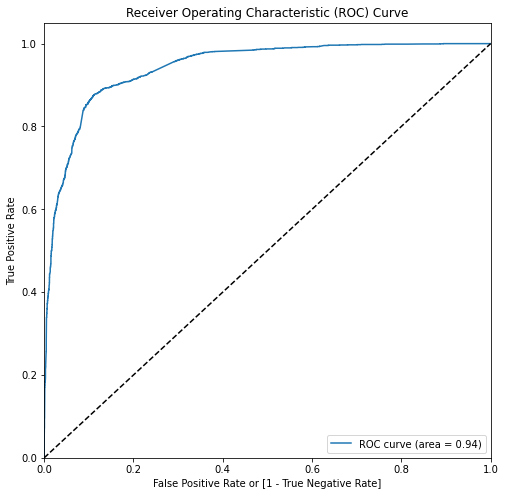

In [110]:
roc(model_1, X_train_1)

Area under ROC curve is 0.94 that is good.

In [111]:
train_perf_1 = model_performance(model_1, X_train_1)
train_perf_1

,probability_cutoff,accuracy,sensitivity,specificity
0.0,0.0,0.382385,1.000000,0.000000
0.1,0.1,0.772176,0.976926,0.645408
0.2,0.2,0.824642,0.932015,0.758163
0.3,0.3,0.861982,0.899876,0.838520
0.4,0.4,0.881991,0.878863,0.883929
0.5,0.5,0.884512,0.853317,0.903827
0.6,0.6,0.868442,0.764730,0.932653
0.7,0.7,0.847802,0.673671,0.955612
0.8,0.8,0.829053,0.592913,0.975255
0.9,0.9,0.781944,0.451586,0.986480


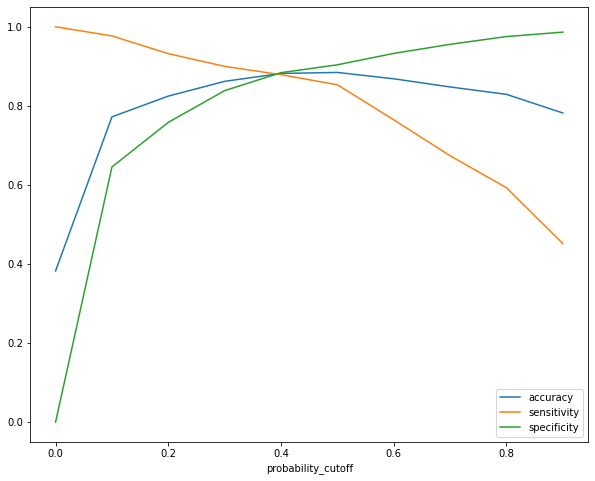

In [112]:
train_perf_1.plot(x='probability_cutoff', y=['accuracy','sensitivity','specificity'], figsize=(10,8))
plt.show()

Optimal cutoff is 0.4

In [113]:
train_cutoff_1 = 0.4
train_perf_1.loc[[train_cutoff_1]]

,probability_cutoff,accuracy,sensitivity,specificity
0.4,0.4,0.881991,0.878863,0.883929


**Assessment:**  
Although statistically model 1 looks good, the features having highest coefficents suggest that specific tags created by sales team has created bias.

### Model 2

In [114]:
# Removing Tags from the training set as it was assigned by sales team themselves
cols_without_tags = list(filter(lambda x: False if x.startswith('Tags_') else True, list(X_train.columns)))

In [115]:
X_train_2 = X_train[cols_without_tags]

In [116]:
# Auto selecting top 15 features
X_train_2 = X_train_2[auto_select_features(15, X_train_2)]

In [117]:
# Training Logistic Regression Model
train_model(y_train, X_train_2).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6347
Model:                            GLM   Df Residuals:                     6331
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2641.7
Date:                Tue, 18 Oct 2022   Deviance:                       5283.3
Time:                        16:09:05   Pearson chi2:                 6.94e+03
No. Iterations:                    21   Pseudo R-squ. (CS):             0.3923
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -1.8923      0.168    -11.242      0.000      -2.222      -1.562
TotalVisits                               2.9651      0.534      5.551      0.000       1.918       4.012
Total Time Spent on Website               4.5983      0.167     27.479      0.000       4.270       4.926
Page Views Per Visit                     -2.2071      0.577     -3.824      0.000      -3.338      -1.076
Lead Origin_Landing Page Submission      -1.1792      0.127     -9.270      0.000      -1.429      -0.930
Lead Origin_Lead Add Form                 5.3273      0.612      8.704      0.000       4.128       6.527
Lead Source_Olark Chat                    1.0519      0.132      7.971      0.000       0.793       1.311
Lead Source_Reference                    -2.0535      0.644     -3.190      0.001      -3.315      -0.792
Do Not Email_Yes                         -1.3867      0.177     -7.839      0.000      -1.733      -1.040
Last Activity_Email Opened                0.8011      0.109      7.335      0.000       0.587       1.015
Last Activity_Olark Chat Conversation    -0.8012      0.187     -4.283      0.000      -1.168      -0.435
Last Activity_Other                       1.4134      0.232      6.090      0.000       0.958       1.868
Last Activity_SMS Sent                    1.9679      0.113     17.489      0.000       1.747       2.188
Specialization_Others                    -1.2345      0.124     -9.965      0.000      -1.477      -0.992
Occupation_Housewife                     22.6370   1.58e+04      0.001      0.999   -3.09e+04     3.1e+04
Occupation_Working Professional           2.6399      0.195     13.526      0.000       2.257       3.022
=========================================================================================================
"""

In [118]:
calculate_vif(X_train_2)

,Feature,VIF
2,Page Views Per Visit,5.03
4,Lead Origin_Lead Add Form,4.74
6,Lead Source_Reference,4.49
3,Lead Origin_Landing Page Submission,3.84
0,TotalVisits,3.46
8,Last Activity_Email Opened,2.79
12,Specialization_Others,2.68
11,Last Activity_SMS Sent,2.49
5,Lead Source_Olark Chat,2.28
1,Total Time Spent on Website,2.17


In [119]:
# Dropping 'Occupation_Housewife' because it has high p-value
X_train_2 = X_train_2.drop('Occupation_Housewife', axis=1)

In [120]:
# Re-train model
train_model(y_train, X_train_2).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6347
Model:                            GLM   Df Residuals:                     6332
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2646.5
Date:                Tue, 18 Oct 2022   Deviance:                       5293.0
Time:                        16:09:05   Pearson chi2:                 6.95e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3913
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -1.8817      0.168    -11.198      0.000      -2.211      -1.552
TotalVisits                               2.9359      0.534      5.497      0.000       1.889       3.983
Total Time Spent on Website               4.6025      0.167     27.521      0.000       4.275       4.930
Page Views Per Visit                     -2.2051      0.577     -3.822      0.000      -3.336      -1.074
Lead Origin_Landing Page Submission      -1.1770      0.127     -9.262      0.000      -1.426      -0.928
Lead Origin_Lead Add Form                 5.3276      0.612      8.705      0.000       4.128       6.527
Lead Source_Olark Chat                    1.0509      0.132      7.965      0.000       0.792       1.309
Lead Source_Reference                    -2.0417      0.644     -3.172      0.002      -3.303      -0.780
Do Not Email_Yes                         -1.3908      0.177     -7.864      0.000      -1.737      -1.044
Last Activity_Email Opened                0.7970      0.109      7.317      0.000       0.583       1.010
Last Activity_Olark Chat Conversation    -0.8076      0.187     -4.320      0.000      -1.174      -0.441
Last Activity_Other                       1.4055      0.232      6.058      0.000       0.951       1.860
Last Activity_SMS Sent                    1.9586      0.112     17.446      0.000       1.739       2.179
Specialization_Others                    -1.2386      0.124    -10.004      0.000      -1.481      -0.996
Occupation_Working Professional           2.6344      0.195     13.501      0.000       2.252       3.017
=========================================================================================================
"""

In [121]:
calculate_vif(X_train_2)

,Feature,VIF
2,Page Views Per Visit,5.03
4,Lead Origin_Lead Add Form,4.74
6,Lead Source_Reference,4.49
3,Lead Origin_Landing Page Submission,3.84
0,TotalVisits,3.46
8,Last Activity_Email Opened,2.79
12,Specialization_Others,2.68
11,Last Activity_SMS Sent,2.49
5,Lead Source_Olark Chat,2.28
1,Total Time Spent on Website,2.17


In [122]:
# Dropping 'Page Views Per Visit' because it has high VIF
X_train_2 = X_train_2.drop('Page Views Per Visit', axis=1)

In [123]:
# Re-train model
train_model(y_train, X_train_2).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6347
Model:                            GLM   Df Residuals:                     6333
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2653.9
Date:                Tue, 18 Oct 2022   Deviance:                       5307.7
Time:                        16:09:06   Pearson chi2:                 6.96e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3899
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -2.0010      0.165    -12.096      0.000      -2.325      -1.677
TotalVisits                               1.9142      0.475      4.026      0.000       0.982       2.846
Total Time Spent on Website               4.5900      0.167     27.491      0.000       4.263       4.917
Lead Origin_Landing Page Submission      -1.2094      0.127     -9.542      0.000      -1.458      -0.961
Lead Origin_Lead Add Form                 5.4650      0.610      8.953      0.000       4.269       6.661
Lead Source_Olark Chat                    1.1880      0.127      9.330      0.000       0.938       1.438
Lead Source_Reference                    -2.0300      0.643     -3.157      0.002      -3.290      -0.770
Do Not Email_Yes                         -1.3887      0.177     -7.862      0.000      -1.735      -1.043
Last Activity_Email Opened                0.7528      0.108      6.969      0.000       0.541       0.964
Last Activity_Olark Chat Conversation    -0.8423      0.187     -4.514      0.000      -1.208      -0.477
Last Activity_Other                       1.3476      0.231      5.837      0.000       0.895       1.800
Last Activity_SMS Sent                    1.8992      0.111     17.149      0.000       1.682       2.116
Specialization_Others                    -1.2142      0.124     -9.831      0.000      -1.456      -0.972
Occupation_Working Professional           2.6275      0.195     13.463      0.000       2.245       3.010
=========================================================================================================
"""

In [124]:
calculate_vif(X_train_2)

,Feature,VIF
3,Lead Origin_Lead Add Form,4.70
5,Lead Source_Reference,4.49
2,Lead Origin_Landing Page Submission,3.48
7,Last Activity_Email Opened,2.67
11,Specialization_Others,2.64
10,Last Activity_SMS Sent,2.38
0,TotalVisits,2.36
4,Lead Source_Olark Chat,2.17
1,Total Time Spent on Website,2.16
8,Last Activity_Olark Chat Conversation,1.79


In [125]:
model_2 = train_model(y_train, X_train_2)

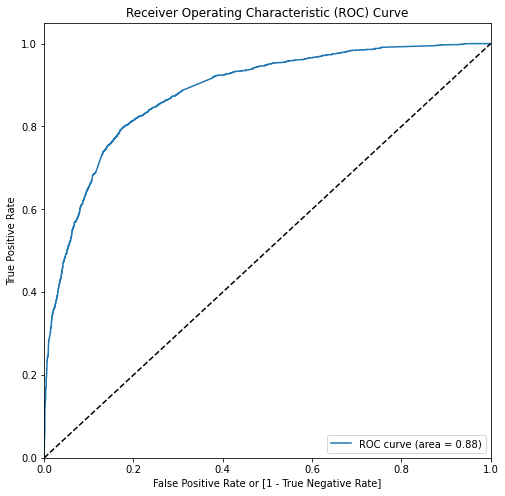

In [126]:
roc(model_2, X_train_2)

Area under ROC curve is 0.88 that is good.

In [127]:
train_perf_2 = model_performance(model_2, X_train_2)
train_perf_2

,probability_cutoff,accuracy,sensitivity,specificity
0.0,0.0,0.382385,1.000000,0.000000
0.1,0.1,0.598550,0.973218,0.366582
0.2,0.2,0.728061,0.923774,0.606888
0.3,0.3,0.793288,0.837248,0.766071
0.4,0.4,0.814873,0.771735,0.841582
0.5,0.5,0.806838,0.663370,0.895663
0.6,0.6,0.795336,0.592501,0.920918
0.7,0.7,0.779581,0.512979,0.944643
0.8,0.8,0.754530,0.409971,0.967857
0.9,0.9,0.708366,0.251339,0.991327


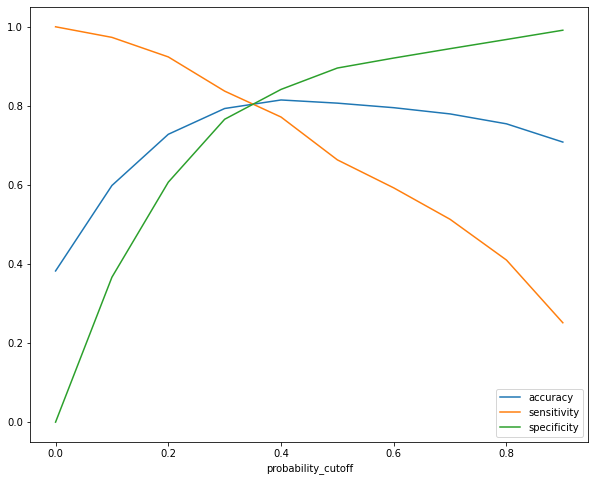

In [128]:
train_perf_2.plot(x='probability_cutoff', y=['accuracy','sensitivity','specificity'], figsize=(10,8))
plt.show()

Optimal cutoff is 0.4

In [129]:
train_cutoff_2 = 0.4
train_perf_2.loc[[train_cutoff_2]]

,probability_cutoff,accuracy,sensitivity,specificity
0.4,0.4,0.814873,0.771735,0.841582


### Model 3

In [130]:
# Continuing without tags
X_train_3 = X_train[cols_without_tags]

In [131]:
# Auto selecting top 20 features
X_train_3 = X_train_3[auto_select_features(20, X_train_3)]

In [132]:
# Training Logistic Regression Model
train_model(y_train, X_train_3).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6347
Model:                            GLM   Df Residuals:                     6326
Model Family:                Binomial   Df Model:                           20
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2637.0
Date:                Tue, 18 Oct 2022   Deviance:                       5274.1
Time:                        16:09:09   Pearson chi2:                 6.92e+03
No. Iterations:                    21   Pseudo R-squ. (CS):             0.3932
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -1.4493      1.203     -1.205      0.228      -3.807       0.909
TotalVisits                               3.0139      0.536      5.626      0.000       1.964       4.064
Total Time Spent on Website               4.6278      0.169     27.455      0.000       4.297       4.958
Page Views Per Visit                     -2.1617      0.579     -3.736      0.000      -3.296      -1.028
Lead Origin_Landing Page Submission      -1.1521      0.129     -8.961      0.000      -1.404      -0.900
Lead Origin_Lead Add Form                 5.3637      0.613      8.757      0.000       4.163       6.564
Lead Origin_Lead Import                   0.7370      0.488      1.509      0.131      -0.220       1.694
Lead Source_Olark Chat                    1.0792      0.134      8.070      0.000       0.817       1.341
Lead Source_Reference                    -2.0507      0.644     -3.183      0.001      -3.313      -0.788
Do Not Email_Yes                         -1.3867      0.177     -7.842      0.000      -1.733      -1.040
Last Activity_Email Opened                0.7935      0.109      7.248      0.000       0.579       1.008
Last Activity_Olark Chat Conversation    -0.8031      0.187     -4.290      0.000      -1.170      -0.436
Last Activity_Other                       1.4267      0.233      6.135      0.000       0.971       1.882
Last Activity_SMS Sent                    1.9776      0.113     17.520      0.000       1.756       2.199
Specialization_Hospitality Management    -0.4894      0.307     -1.595      0.111      -1.091       0.112
Specialization_Others                    -1.2208      0.125     -9.806      0.000      -1.465      -0.977
Occupation_Housewife                     22.1539   1.58e+04      0.001      0.999    -3.1e+04     3.1e+04
Occupation_Other                         -0.1289      1.417     -0.091      0.927      -2.905       2.647
Occupation_Student                       -0.0124      1.217     -0.010      0.992      -2.397       2.373
Occupation_Unemployed                    -0.4960      1.196     -0.415      0.678      -2.840       1.848
Occupation_Working Professional           2.1680      1.211      1.791      0.073      -0.205       4.541
=========================================================================================================
"""

In [133]:
calculate_vif(X_train_3)

,Feature,VIF
18,Occupation_Unemployed,20.39
3,Lead Origin_Landing Page Submission,7.38
2,Page Views Per Visit,5.26
4,Lead Origin_Lead Add Form,4.90
14,Specialization_Others,4.63
7,Lead Source_Reference,4.59
0,TotalVisits,3.56
9,Last Activity_Email Opened,3.37
12,Last Activity_SMS Sent,2.83
6,Lead Source_Olark Chat,2.81


In [134]:
# Dropping 'Occupation_Unemployed' because it has both high p-value & high VIF
X_train_3 = X_train_3.drop('Occupation_Unemployed', axis=1)

In [135]:
# Re-train model
train_model(y_train, X_train_3).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6347
Model:                            GLM   Df Residuals:                     6327
Model Family:                Binomial   Df Model:                           19
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2637.1
Date:                Tue, 18 Oct 2022   Deviance:                       5274.2
Time:                        16:09:09   Pearson chi2:                 6.92e+03
No. Iterations:                    21   Pseudo R-squ. (CS):             0.3931
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -1.9435      0.171    -11.344      0.000      -2.279      -1.608
TotalVisits                               3.0180      0.536      5.634      0.000       1.968       4.068
Total Time Spent on Website               4.6290      0.169     27.468      0.000       4.299       4.959
Page Views Per Visit                     -2.1609      0.578     -3.736      0.000      -3.295      -1.027
Lead Origin_Landing Page Submission      -1.1539      0.129     -8.978      0.000      -1.406      -0.902
Lead Origin_Lead Add Form                 5.3638      0.613      8.757      0.000       4.163       6.564
Lead Origin_Lead Import                   0.7362      0.488      1.508      0.132      -0.221       1.693
Lead Source_Olark Chat                    1.0790      0.134      8.069      0.000       0.817       1.341
Lead Source_Reference                    -2.0495      0.644     -3.181      0.001      -3.312      -0.787
Do Not Email_Yes                         -1.3877      0.177     -7.849      0.000      -1.734      -1.041
Last Activity_Email Opened                0.7928      0.109      7.243      0.000       0.578       1.007
Last Activity_Olark Chat Conversation    -0.8042      0.187     -4.296      0.000      -1.171      -0.437
Last Activity_Other                       1.4287      0.232      6.151      0.000       0.973       1.884
Last Activity_SMS Sent                    1.9766      0.113     17.515      0.000       1.755       2.198
Specialization_Hospitality Management    -0.4901      0.307     -1.598      0.110      -1.091       0.111
Specialization_Others                    -1.2219      0.125     -9.812      0.000      -1.466      -0.978
Occupation_Housewife                     22.6490   1.58e+04      0.001      0.999   -3.09e+04     3.1e+04
Occupation_Other                          0.3659      0.764      0.479      0.632      -1.131       1.863
Occupation_Student                        0.4832      0.230      2.099      0.036       0.032       0.934
Occupation_Working Professional           2.6635      0.196     13.615      0.000       2.280       3.047
=========================================================================================================
"""

In [136]:
calculate_vif(X_train_3)

,Feature,VIF
2,Page Views Per Visit,5.04
4,Lead Origin_Lead Add Form,4.75
7,Lead Source_Reference,4.50
3,Lead Origin_Landing Page Submission,3.86
0,TotalVisits,3.46
9,Last Activity_Email Opened,2.84
14,Specialization_Others,2.69
12,Last Activity_SMS Sent,2.51
6,Lead Source_Olark Chat,2.30
1,Total Time Spent on Website,2.18


In [137]:
# Dropping 'Occupation_Housewife' because it has high p-value
X_train_3 = X_train_3.drop('Occupation_Housewife', axis=1)

In [138]:
# Re-train model
train_model(y_train, X_train_3).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6347
Model:                            GLM   Df Residuals:                     6328
Model Family:                Binomial   Df Model:                           18
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2642.0
Date:                Tue, 18 Oct 2022   Deviance:                       5283.9
Time:                        16:09:10   Pearson chi2:                 6.94e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3922
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -1.9323      0.171    -11.298      0.000      -2.268      -1.597
TotalVisits                               2.9884      0.536      5.580      0.000       1.939       4.038
Total Time Spent on Website               4.6333      0.168     27.511      0.000       4.303       4.963
Page Views Per Visit                     -2.1592      0.578     -3.734      0.000      -3.293      -1.026
Lead Origin_Landing Page Submission      -1.1519      0.128     -8.970      0.000      -1.404      -0.900
Lead Origin_Lead Add Form                 5.3638      0.612      8.758      0.000       4.163       6.564
Lead Origin_Lead Import                   0.7324      0.488      1.500      0.134      -0.225       1.689
Lead Source_Olark Chat                    1.0778      0.134      8.063      0.000       0.816       1.340
Lead Source_Reference                    -2.0372      0.644     -3.163      0.002      -3.300      -0.775
Do Not Email_Yes                         -1.3918      0.177     -7.874      0.000      -1.738      -1.045
Last Activity_Email Opened                0.7888      0.109      7.225      0.000       0.575       1.003
Last Activity_Olark Chat Conversation    -0.8106      0.187     -4.333      0.000      -1.177      -0.444
Last Activity_Other                       1.4206      0.232      6.118      0.000       0.966       1.876
Last Activity_SMS Sent                    1.9672      0.113     17.472      0.000       1.747       2.188
Specialization_Hospitality Management    -0.4955      0.307     -1.615      0.106      -1.097       0.106
Specialization_Others                    -1.2263      0.124     -9.854      0.000      -1.470      -0.982
Occupation_Other                          0.3594      0.763      0.471      0.638      -1.137       1.856
Occupation_Student                        0.4779      0.230      2.076      0.038       0.027       0.929
Occupation_Working Professional           2.6580      0.196     13.590      0.000       2.275       3.041
=========================================================================================================
"""

In [139]:
calculate_vif(X_train_3)

,Feature,VIF
2,Page Views Per Visit,5.04
4,Lead Origin_Lead Add Form,4.75
7,Lead Source_Reference,4.50
3,Lead Origin_Landing Page Submission,3.86
0,TotalVisits,3.46
9,Last Activity_Email Opened,2.84
14,Specialization_Others,2.69
12,Last Activity_SMS Sent,2.51
6,Lead Source_Olark Chat,2.30
1,Total Time Spent on Website,2.18


In [140]:
# Dropping 'Occupation_Other' because it has high p-value
X_train_3 = X_train_3.drop('Occupation_Other', axis=1)

In [141]:
# Re-train model
train_model(y_train, X_train_3).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6347
Model:                            GLM   Df Residuals:                     6329
Model Family:                Binomial   Df Model:                           17
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2642.1
Date:                Tue, 18 Oct 2022   Deviance:                       5284.2
Time:                        16:09:10   Pearson chi2:                 6.94e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3922
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -1.9304      0.171    -11.294      0.000      -2.265      -1.595
TotalVisits                               2.9950      0.535      5.598      0.000       1.946       4.044
Total Time Spent on Website               4.6352      0.168     27.527      0.000       4.305       4.965
Page Views Per Visit                     -2.1602      0.578     -3.736      0.000      -3.294      -1.027
Lead Origin_Landing Page Submission      -1.1534      0.128     -8.987      0.000      -1.405      -0.902
Lead Origin_Lead Add Form                 5.3643      0.612      8.759      0.000       4.164       6.565
Lead Origin_Lead Import                   0.7318      0.488      1.499      0.134      -0.225       1.689
Lead Source_Olark Chat                    1.0789      0.134      8.072      0.000       0.817       1.341
Lead Source_Reference                    -2.0380      0.644     -3.164      0.002      -3.300      -0.776
Do Not Email_Yes                         -1.3904      0.177     -7.867      0.000      -1.737      -1.044
Last Activity_Email Opened                0.7884      0.109      7.222      0.000       0.574       1.002
Last Activity_Olark Chat Conversation    -0.8121      0.187     -4.341      0.000      -1.179      -0.445
Last Activity_Other                       1.4188      0.232      6.111      0.000       0.964       1.874
Last Activity_SMS Sent                    1.9660      0.113     17.466      0.000       1.745       2.187
Specialization_Hospitality Management    -0.4967      0.307     -1.619      0.105      -1.098       0.105
Specialization_Others                    -1.2283      0.124     -9.877      0.000      -1.472      -0.985
Occupation_Student                        0.4770      0.230      2.072      0.038       0.026       0.928
Occupation_Working Professional           2.6571      0.196     13.585      0.000       2.274       3.040
=========================================================================================================
"""

In [142]:
calculate_vif(X_train_3)

,Feature,VIF
2,Page Views Per Visit,5.04
4,Lead Origin_Lead Add Form,4.75
7,Lead Source_Reference,4.50
3,Lead Origin_Landing Page Submission,3.86
0,TotalVisits,3.46
9,Last Activity_Email Opened,2.84
14,Specialization_Others,2.69
12,Last Activity_SMS Sent,2.51
6,Lead Source_Olark Chat,2.30
1,Total Time Spent on Website,2.18


In [143]:
# Dropping 'Lead Origin_Lead Import' because it has high p-value
X_train_3 = X_train_3.drop('Lead Origin_Lead Import', axis=1)

In [144]:
# Re-train model
train_model(y_train, X_train_3).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6347
Model:                            GLM   Df Residuals:                     6330
Model Family:                Binomial   Df Model:                           16
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2643.1
Date:                Tue, 18 Oct 2022   Deviance:                       5286.3
Time:                        16:09:10   Pearson chi2:                 6.93e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3920
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -1.8868      0.168    -11.214      0.000      -2.217      -1.557
TotalVisits                               2.9653      0.535      5.544      0.000       1.917       4.014
Total Time Spent on Website               4.6127      0.167     27.541      0.000       4.284       4.941
Page Views Per Visit                     -2.2170      0.578     -3.839      0.000      -3.349      -1.085
Lead Origin_Landing Page Submission      -1.1823      0.127     -9.305      0.000      -1.431      -0.933
Lead Origin_Lead Add Form                 5.3362      0.612      8.717      0.000       4.136       6.536
Lead Source_Olark Chat                    1.0491      0.132      7.947      0.000       0.790       1.308
Lead Source_Reference                    -2.0475      0.644     -3.178      0.001      -3.310      -0.785
Do Not Email_Yes                         -1.3894      0.177     -7.864      0.000      -1.736      -1.043
Last Activity_Email Opened                0.7952      0.109      7.295      0.000       0.582       1.009
Last Activity_Olark Chat Conversation    -0.8110      0.187     -4.335      0.000      -1.178      -0.444
Last Activity_Other                       1.4189      0.232      6.114      0.000       0.964       1.874
Last Activity_SMS Sent                    1.9689      0.112     17.504      0.000       1.748       2.189
Specialization_Hospitality Management    -0.4994      0.307     -1.628      0.104      -1.101       0.102
Specialization_Others                    -1.2483      0.124    -10.072      0.000      -1.491      -1.005
Occupation_Student                        0.4733      0.230      2.056      0.040       0.022       0.925
Occupation_Working Professional           2.6572      0.196     13.589      0.000       2.274       3.040
=========================================================================================================
"""

In [145]:
calculate_vif(X_train_3)

,Feature,VIF
2,Page Views Per Visit,5.03
4,Lead Origin_Lead Add Form,4.74
6,Lead Source_Reference,4.50
3,Lead Origin_Landing Page Submission,3.86
0,TotalVisits,3.46
8,Last Activity_Email Opened,2.79
13,Specialization_Others,2.69
11,Last Activity_SMS Sent,2.49
5,Lead Source_Olark Chat,2.28
1,Total Time Spent on Website,2.17


In [146]:
# Dropping 'Specialization_Hospitality Management' because it has high p-value
X_train_3 = X_train_3.drop('Specialization_Hospitality Management', axis=1)

In [147]:
# Re-train model
train_model(y_train, X_train_3).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6347
Model:                            GLM   Df Residuals:                     6331
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2644.5
Date:                Tue, 18 Oct 2022   Deviance:                       5288.9
Time:                        16:09:11   Pearson chi2:                 6.95e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3917
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -1.8944      0.168    -11.264      0.000      -2.224      -1.565
TotalVisits                               2.9551      0.534      5.530      0.000       1.908       4.002
Total Time Spent on Website               4.6045      0.167     27.521      0.000       4.277       4.932
Page Views Per Visit                     -2.2149      0.577     -3.837      0.000      -3.346      -1.084
Lead Origin_Landing Page Submission      -1.1786      0.127     -9.279      0.000      -1.428      -0.930
Lead Origin_Lead Add Form                 5.3336      0.612      8.713      0.000       4.134       6.533
Lead Source_Olark Chat                    1.0464      0.132      7.931      0.000       0.788       1.305
Lead Source_Reference                    -2.0620      0.644     -3.202      0.001      -3.324      -0.800
Do Not Email_Yes                         -1.3910      0.177     -7.871      0.000      -1.737      -1.045
Last Activity_Email Opened                0.7951      0.109      7.297      0.000       0.582       1.009
Last Activity_Olark Chat Conversation    -0.8113      0.187     -4.339      0.000      -1.178      -0.445
Last Activity_Other                       1.4168      0.232      6.104      0.000       0.962       1.872
Last Activity_SMS Sent                    1.9665      0.112     17.495      0.000       1.746       2.187
Specialization_Others                    -1.2362      0.124     -9.998      0.000      -1.479      -0.994
Occupation_Student                        0.4699      0.230      2.045      0.041       0.019       0.920
Occupation_Working Professional           2.6465      0.195     13.553      0.000       2.264       3.029
=========================================================================================================
"""

In [148]:
calculate_vif(X_train_3)

,Feature,VIF
2,Page Views Per Visit,5.03
4,Lead Origin_Lead Add Form,4.74
6,Lead Source_Reference,4.50
3,Lead Origin_Landing Page Submission,3.85
0,TotalVisits,3.46
8,Last Activity_Email Opened,2.79
12,Specialization_Others,2.69
11,Last Activity_SMS Sent,2.49
5,Lead Source_Olark Chat,2.28
1,Total Time Spent on Website,2.17


In [149]:
# Dropping 'Page Views Per Visit' because it has high VIF
X_train_3 = X_train_3.drop('Page Views Per Visit', axis=1)

In [150]:
# Re-train model
train_model(y_train, X_train_3).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6347
Model:                            GLM   Df Residuals:                     6332
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2651.9
Date:                Tue, 18 Oct 2022   Deviance:                       5303.8
Time:                        16:09:12   Pearson chi2:                 6.95e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3903
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -2.0135      0.166    -12.160      0.000      -2.338      -1.689
TotalVisits                               1.9283      0.476      4.054      0.000       0.996       2.861
Total Time Spent on Website               4.5917      0.167     27.491      0.000       4.264       4.919
Lead Origin_Landing Page Submission      -1.2114      0.127     -9.563      0.000      -1.460      -0.963
Lead Origin_Lead Add Form                 5.4710      0.611      8.960      0.000       4.274       6.668
Lead Source_Olark Chat                    1.1839      0.127      9.296      0.000       0.934       1.434
Lead Source_Reference                    -2.0500      0.643     -3.187      0.001      -3.311      -0.789
Do Not Email_Yes                         -1.3885      0.177     -7.866      0.000      -1.734      -1.043
Last Activity_Email Opened                0.7506      0.108      6.947      0.000       0.539       0.962
Last Activity_Olark Chat Conversation    -0.8459      0.187     -4.533      0.000      -1.212      -0.480
Last Activity_Other                       1.3583      0.231      5.881      0.000       0.906       1.811
Last Activity_SMS Sent                    1.9066      0.111     17.197      0.000       1.689       2.124
Specialization_Others                    -1.2119      0.123     -9.826      0.000      -1.454      -0.970
Occupation_Student                        0.4636      0.230      2.013      0.044       0.012       0.915
Occupation_Working Professional           2.6392      0.195     13.513      0.000       2.256       3.022
=========================================================================================================
"""

In [151]:
calculate_vif(X_train_3)

,Feature,VIF
3,Lead Origin_Lead Add Form,4.70
5,Lead Source_Reference,4.49
2,Lead Origin_Landing Page Submission,3.49
7,Last Activity_Email Opened,2.67
11,Specialization_Others,2.65
10,Last Activity_SMS Sent,2.38
0,TotalVisits,2.36
4,Lead Source_Olark Chat,2.17
1,Total Time Spent on Website,2.16
8,Last Activity_Olark Chat Conversation,1.79


In [152]:
model_3 = train_model(y_train, X_train_3)

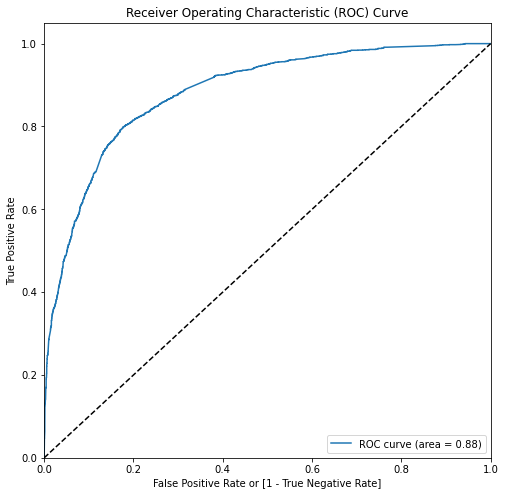

In [153]:
roc(model_3, X_train_3)

Area under ROC curve is 0.88 that is good.

In [154]:
train_perf_3 = model_performance(model_3, X_train_3)
train_perf_3

,probability_cutoff,accuracy,sensitivity,specificity
0.0,0.0,0.382385,1.000000,0.000000
0.1,0.1,0.599811,0.972806,0.368878
0.2,0.2,0.727430,0.924186,0.605612
0.3,0.3,0.792028,0.837660,0.763776
0.4,0.4,0.815346,0.772971,0.841582
0.5,0.5,0.807468,0.665843,0.895153
0.6,0.6,0.795809,0.593325,0.921173
0.7,0.7,0.780369,0.514627,0.944898
0.8,0.8,0.754530,0.410383,0.967602
0.9,0.9,0.710414,0.256696,0.991327


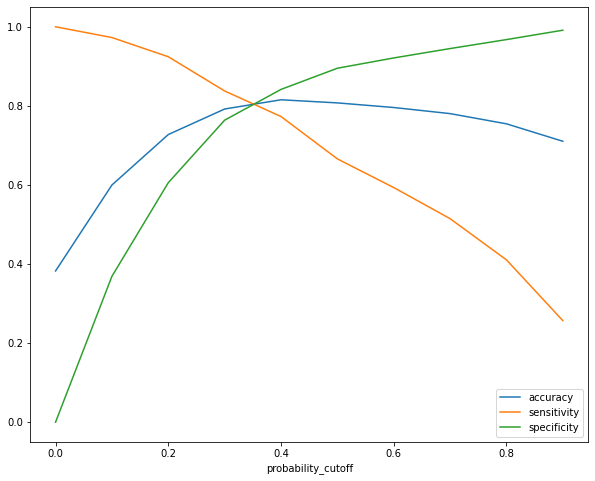

In [155]:
train_perf_3.plot(x='probability_cutoff', y=['accuracy','sensitivity','specificity'], figsize=(10,8))
plt.show()

Optimal cutoff is 0.4

In [156]:
train_cutoff_3 = 0.4
train_perf_3.loc[[train_cutoff_3]]

,probability_cutoff,accuracy,sensitivity,specificity
0.4,0.4,0.815346,0.772971,0.841582


### Model 4

In [157]:
# Continuing from Model 3 with aim to further reduce VIF
X_train_4 = X_train_3.copy()

In [169]:
# Training Logistic Regression Model
train_model(y_train, X_train_4).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6347
Model:                            GLM   Df Residuals:                     6332
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2651.9
Date:                Tue, 18 Oct 2022   Deviance:                       5303.8
Time:                        16:09:58   Pearson chi2:                 6.95e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3903
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -2.0135      0.166    -12.160      0.000      -2.338      -1.689
TotalVisits                               1.9283      0.476      4.054      0.000       0.996       2.861
Total Time Spent on Website               4.5917      0.167     27.491      0.000       4.264       4.919
Lead Origin_Landing Page Submission      -1.2114      0.127     -9.563      0.000      -1.460      -0.963
Lead Origin_Lead Add Form                 5.4710      0.611      8.960      0.000       4.274       6.668
Lead Source_Olark Chat                    1.1839      0.127      9.296      0.000       0.934       1.434
Lead Source_Reference                    -2.0500      0.643     -3.187      0.001      -3.311      -0.789
Do Not Email_Yes                         -1.3885      0.177     -7.866      0.000      -1.734      -1.043
Last Activity_Email Opened                0.7506      0.108      6.947      0.000       0.539       0.962
Last Activity_Olark Chat Conversation    -0.8459      0.187     -4.533      0.000      -1.212      -0.480
Last Activity_Other                       1.3583      0.231      5.881      0.000       0.906       1.811
Last Activity_SMS Sent                    1.9066      0.111     17.197      0.000       1.689       2.124
Specialization_Others                    -1.2119      0.123     -9.826      0.000      -1.454      -0.970
Occupation_Student                        0.4636      0.230      2.013      0.044       0.012       0.915
Occupation_Working Professional           2.6392      0.195     13.513      0.000       2.256       3.022
=========================================================================================================
"""

In [170]:
calculate_vif(X_train_4)

,Feature,VIF
3,Lead Origin_Lead Add Form,4.70
5,Lead Source_Reference,4.49
2,Lead Origin_Landing Page Submission,3.49
7,Last Activity_Email Opened,2.67
11,Specialization_Others,2.65
10,Last Activity_SMS Sent,2.38
0,TotalVisits,2.36
4,Lead Source_Olark Chat,2.17
1,Total Time Spent on Website,2.16
8,Last Activity_Olark Chat Conversation,1.79


In [171]:
# Dropping 'Lead Origin_Lead Add Form' because it has high VIF
X_train_4 = X_train_4.drop('Lead Origin_Lead Add Form', axis=1)

In [172]:
# Re-train model
train_model(y_train, X_train_4).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6347
Model:                            GLM   Df Residuals:                     6333
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2789.6
Date:                Tue, 18 Oct 2022   Deviance:                       5579.1
Time:                        16:11:34   Pearson chi2:                 6.68e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3633
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -1.5483      0.157     -9.857      0.000      -1.856      -1.240
TotalVisits                               0.7678      0.476      1.614      0.107      -0.165       1.700
Total Time Spent on Website               4.1829      0.160     26.077      0.000       3.869       4.497
Lead Origin_Landing Page Submission      -1.4675      0.123    -11.897      0.000      -1.709      -1.226
Lead Source_Olark Chat                    0.6251      0.117      5.327      0.000       0.395       0.855
Lead Source_Reference                     2.8610      0.240     11.914      0.000       2.390       3.332
Do Not Email_Yes                         -1.2137      0.167     -7.280      0.000      -1.540      -0.887
Last Activity_Email Opened                0.7835      0.105      7.485      0.000       0.578       0.989
Last Activity_Olark Chat Conversation    -0.8638      0.182     -4.737      0.000      -1.221      -0.506
Last Activity_Other                       1.2855      0.226      5.697      0.000       0.843       1.728
Last Activity_SMS Sent                    1.9797      0.107     18.424      0.000       1.769       2.190
Specialization_Others                    -1.1125      0.120     -9.289      0.000      -1.347      -0.878
Occupation_Student                        0.4359      0.225      1.934      0.053      -0.006       0.878
Occupation_Working Professional           2.5712      0.193     13.316      0.000       2.193       2.950
=========================================================================================================
"""

In [173]:
calculate_vif(X_train_4)

,Feature,VIF
2,Lead Origin_Landing Page Submission,3.49
6,Last Activity_Email Opened,2.64
10,Specialization_Others,2.59
0,TotalVisits,2.35
9,Last Activity_SMS Sent,2.31
1,Total Time Spent on Website,2.15
3,Lead Source_Olark Chat,2.11
7,Last Activity_Olark Chat Conversation,1.79
4,Lead Source_Reference,1.27
5,Do Not Email_Yes,1.21


In [174]:
# Dropping 'TotalVisits' because it has high p-value
X_train_4 = X_train_4.drop('TotalVisits', axis=1)

In [175]:
# Re-train model
train_model(y_train, X_train_4).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6347
Model:                            GLM   Df Residuals:                     6334
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2790.9
Date:                Tue, 18 Oct 2022   Deviance:                       5581.7
Time:                        16:13:08   Pearson chi2:                 6.70e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3630
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -1.4686      0.149     -9.867      0.000      -1.760      -1.177
Total Time Spent on Website               4.2058      0.160     26.309      0.000       3.892       4.519
Lead Origin_Landing Page Submission      -1.4646      0.123    -11.882      0.000      -1.706      -1.223
Lead Source_Olark Chat                    0.5737      0.113      5.091      0.000       0.353       0.795
Lead Source_Reference                     2.7991      0.237     11.814      0.000       2.335       3.264
Do Not Email_Yes                         -1.2196      0.167     -7.322      0.000      -1.546      -0.893
Last Activity_Email Opened                0.7796      0.105      7.451      0.000       0.575       0.985
Last Activity_Olark Chat Conversation    -0.8629      0.182     -4.735      0.000      -1.220      -0.506
Last Activity_Other                       1.2957      0.226      5.744      0.000       0.854       1.738
Last Activity_SMS Sent                    1.9710      0.107     18.379      0.000       1.761       2.181
Specialization_Others                    -1.1334      0.119     -9.519      0.000      -1.367      -0.900
Occupation_Student                        0.4303      0.225      1.909      0.056      -0.011       0.872
Occupation_Working Professional           2.5641      0.193     13.297      0.000       2.186       2.942
=========================================================================================================
"""

In [176]:
calculate_vif(X_train_4)

,Feature,VIF
1,Lead Origin_Landing Page Submission,3.07
5,Last Activity_Email Opened,2.58
9,Specialization_Others,2.53
8,Last Activity_SMS Sent,2.29
0,Total Time Spent on Website,2.05
2,Lead Source_Olark Chat,2.04
6,Last Activity_Olark Chat Conversation,1.77
3,Lead Source_Reference,1.26
4,Do Not Email_Yes,1.20
11,Occupation_Working Professional,1.20


In [177]:
# Dropping 'Occupation_Student' because it has high p-value
X_train_4 = X_train_4.drop('Occupation_Student', axis=1)

In [178]:
# Re-train model
train_model(y_train, X_train_4).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6347
Model:                            GLM   Df Residuals:                     6335
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2792.6
Date:                Tue, 18 Oct 2022   Deviance:                       5585.3
Time:                        16:14:19   Pearson chi2:                 6.70e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3627
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -1.4593      0.149     -9.809      0.000      -1.751      -1.168
Total Time Spent on Website               4.2035      0.160     26.304      0.000       3.890       4.517
Lead Origin_Landing Page Submission      -1.4620      0.123    -11.852      0.000      -1.704      -1.220
Lead Source_Olark Chat                    0.5784      0.113      5.134      0.000       0.358       0.799
Lead Source_Reference                     2.8147      0.237     11.893      0.000       2.351       3.279
Do Not Email_Yes                         -1.2192      0.167     -7.315      0.000      -1.546      -0.893
Last Activity_Email Opened                0.7817      0.105      7.473      0.000       0.577       0.987
Last Activity_Olark Chat Conversation    -0.8590      0.182     -4.713      0.000      -1.216      -0.502
Last Activity_Other                       1.2859      0.226      5.702      0.000       0.844       1.728
Last Activity_SMS Sent                    1.9648      0.107     18.336      0.000       1.755       2.175
Specialization_Others                    -1.1347      0.119     -9.514      0.000      -1.368      -0.901
Occupation_Working Professional           2.5534      0.193     13.250      0.000       2.176       2.931
=========================================================================================================
"""

In [180]:
calculate_vif(X_train_4)

,Feature,VIF
1,Lead Origin_Landing Page Submission,3.06
5,Last Activity_Email Opened,2.58
9,Specialization_Others,2.53
8,Last Activity_SMS Sent,2.29
0,Total Time Spent on Website,2.05
2,Lead Source_Olark Chat,2.04
6,Last Activity_Olark Chat Conversation,1.77
3,Lead Source_Reference,1.25
4,Do Not Email_Yes,1.20
10,Occupation_Working Professional,1.20


In [181]:
model_4 = train_model(y_train, X_train_4)

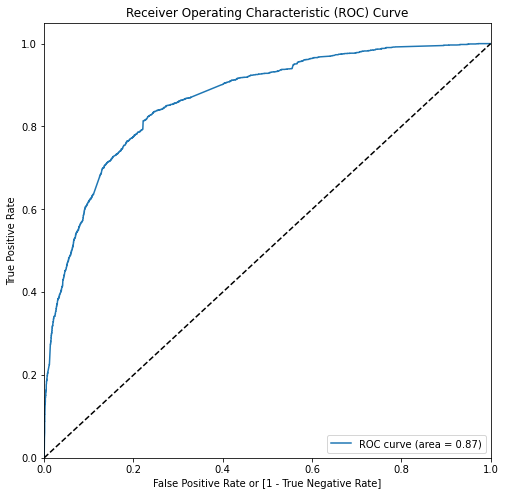

In [182]:
roc(model_4, X_train_4)

Area under ROC curve is 0.87 that is good.

In [183]:
train_perf_4 = model_performance(model_4, X_train_4)
train_perf_4

,probability_cutoff,accuracy,sensitivity,specificity
0.0,0.0,0.382385,1.000000,0.000000
0.1,0.1,0.567827,0.976926,0.314541
0.2,0.2,0.703482,0.912237,0.574235
0.3,0.3,0.776272,0.841780,0.735714
0.4,0.4,0.795336,0.751133,0.822704
0.5,0.5,0.792816,0.629584,0.893878
0.6,0.6,0.782732,0.557066,0.922449
0.7,0.7,0.766977,0.478368,0.945663
0.8,0.8,0.741610,0.370004,0.971684
0.9,0.9,0.691665,0.207252,0.991582


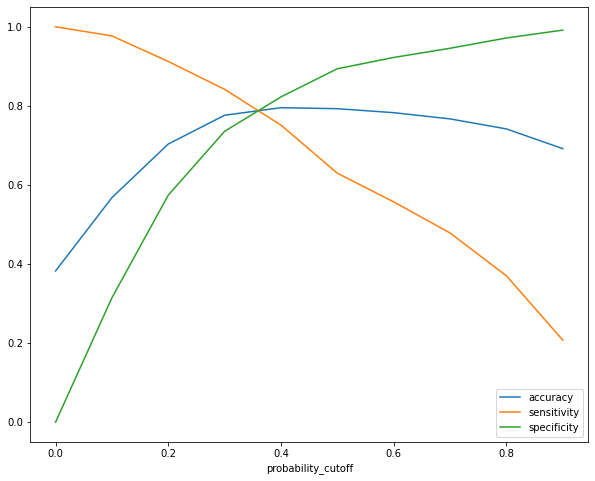

In [184]:
train_perf_4.plot(x='probability_cutoff', y=['accuracy','sensitivity','specificity'], figsize=(10,8))
plt.show()

Optimal cutoff is 0.4

In [185]:
train_cutoff_4 = 0.4
train_perf_4.loc[[train_cutoff_4]]

,probability_cutoff,accuracy,sensitivity,specificity
0.4,0.4,0.795336,0.751133,0.822704


**Assessment:**  
Accuracy further dropped. So, reducing VIF didn't add any value.

### Model 5

## Model Evaluation

In [158]:
# Feature Scaling on Test Set
df_test[num_vars] = scaler.transform(df_test[num_vars])

In [159]:
# Extract target variable
y_test = df_test.pop('Converted')
X_test = df_test

### Model 1

In [160]:
test_perf_1 = model_performance(model_1, X_test[X_train_1.columns], y_test)
test_perf_1

,probability_cutoff,accuracy,sensitivity,specificity
0.0,0.0,0.370085,1.000000,0.000000
0.1,0.1,0.773613,0.976167,0.654609
0.2,0.2,0.826167,0.930487,0.764877
0.3,0.3,0.865491,0.896723,0.847141
0.4,0.4,0.880926,0.872890,0.885648
0.5,0.5,0.882396,0.846077,0.903734
0.6,0.6,0.868798,0.767627,0.928238
0.7,0.7,0.852995,0.676266,0.956826
0.8,0.8,0.836090,0.603774,0.972579
0.9,0.9,0.784638,0.447865,0.982497


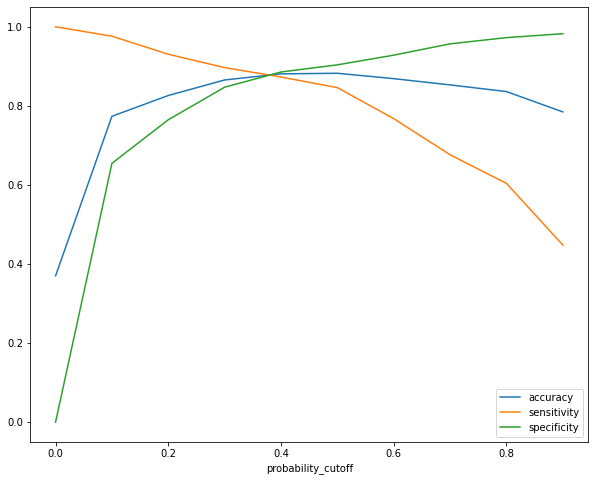

In [161]:
test_perf_1.plot(x='probability_cutoff', y=['accuracy','sensitivity','specificity'], figsize=(10,8))
plt.show()

In [162]:
test_cutoff_1 = 0.4
test_perf_1.loc[[test_cutoff_1]]

,probability_cutoff,accuracy,sensitivity,specificity
0.4,0.4,0.880926,0.87289,0.885648


### Model 2

In [163]:
test_perf_2 = model_performance(model_2, X_test[X_train_2.columns], y_test)
test_perf_2

,probability_cutoff,accuracy,sensitivity,specificity
0.0,0.0,0.370085,1.000000,0.000000
0.1,0.1,0.588754,0.973188,0.362894
0.2,0.2,0.728041,0.921549,0.614352
0.3,0.3,0.785373,0.839126,0.753792
0.4,0.4,0.810731,0.789474,0.823221
0.5,0.5,0.808894,0.681231,0.883897
0.6,0.6,0.804484,0.617676,0.914236
0.7,0.7,0.789783,0.534260,0.939907
0.8,0.8,0.759280,0.411122,0.963827
0.9,0.9,0.713708,0.248262,0.987165


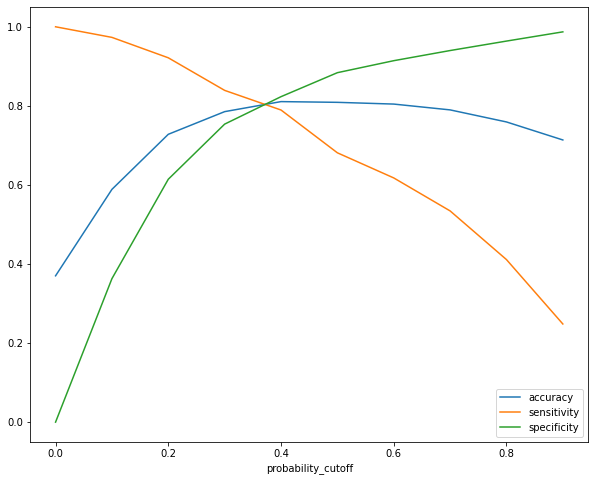

In [164]:
test_perf_2.plot(x='probability_cutoff', y=['accuracy','sensitivity','specificity'], figsize=(10,8))
plt.show()

In [165]:
test_cutoff_2 = 0.4
test_perf_2.loc[[test_cutoff_2]]

,probability_cutoff,accuracy,sensitivity,specificity
0.4,0.4,0.810731,0.789474,0.823221


### Model 3

In [166]:
test_perf_3 = model_performance(model_3, X_test[X_train_3.columns], y_test)
test_perf_3

,probability_cutoff,accuracy,sensitivity,specificity
0.0,0.0,0.370085,1.000000,0.000000
0.1,0.1,0.590592,0.973188,0.365811
0.2,0.2,0.726939,0.922542,0.612019
0.3,0.3,0.782800,0.839126,0.749708
0.4,0.4,0.809996,0.789474,0.822054
0.5,0.5,0.809261,0.682224,0.883897
0.6,0.6,0.803749,0.615690,0.914236
0.7,0.7,0.789416,0.533267,0.939907
0.8,0.8,0.761117,0.415094,0.964411
0.9,0.9,0.714076,0.249255,0.987165


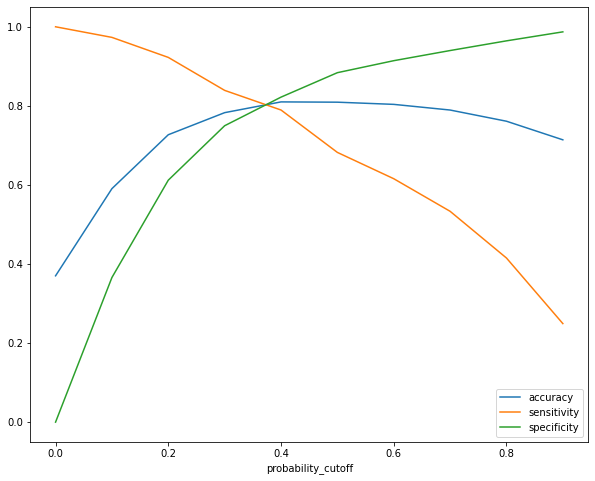

In [167]:
test_perf_3.plot(x='probability_cutoff', y=['accuracy','sensitivity','specificity'], figsize=(10,8))
plt.show()

In [168]:
test_cutoff_3 = 0.4
test_perf_3.loc[[test_cutoff_3]]

,probability_cutoff,accuracy,sensitivity,specificity
0.4,0.4,0.809996,0.789474,0.822054


### Model 4

In [186]:
test_perf_4 = model_performance(model_4, X_test[X_train_4.columns], y_test)
test_perf_4

,probability_cutoff,accuracy,sensitivity,specificity
0.0,0.0,0.370085,1.000000,0.000000
0.1,0.1,0.554576,0.973188,0.308635
0.2,0.2,0.712606,0.919563,0.591015
0.3,0.3,0.773613,0.846077,0.731039
0.4,0.4,0.789048,0.758689,0.806884
0.5,0.5,0.790518,0.637537,0.880397
0.6,0.6,0.787211,0.577954,0.910152
0.7,0.7,0.778758,0.503476,0.940490
0.8,0.8,0.750092,0.376365,0.969662
0.9,0.9,0.696435,0.200596,0.987748


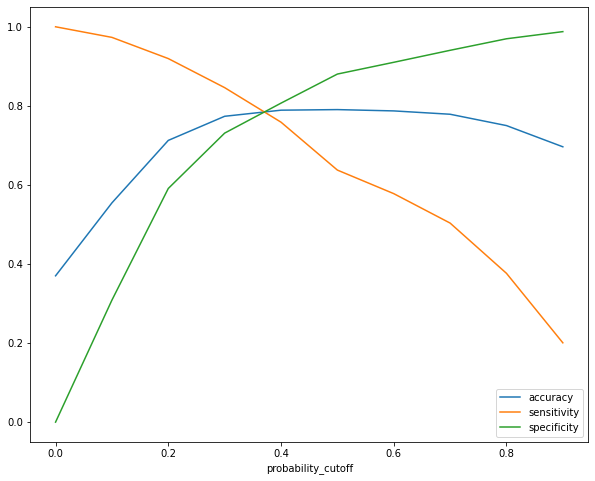

In [187]:
test_perf_4.plot(x='probability_cutoff', y=['accuracy','sensitivity','specificity'], figsize=(10,8))
plt.show()

In [188]:
test_cutoff_4 = 0.4
test_perf_4.loc[[test_cutoff_4]]

,probability_cutoff,accuracy,sensitivity,specificity
0.4,0.4,0.789048,0.758689,0.806884


### Model 5